# Spectral methods / digital signal processing for noise removal

In this notebook we explore Fourier and Wavelets methods for denosing financial time series data. The goal is to determine if a denoised signal provides improved forecasting results. Some considerations and difficulties with this approach:
- you cant denoise the the entire signal, then split the denoised signal into a testing and training set. This would cause information leakage - ie using testing set knowledge in the transformation. 
    - potential work around is to denoise testing set only and then predict on noisy set
    - what would be the result of this? Perhaps smoother predictions, but these smoother predictions may not results in improved evaluation metrics such as RMSE or DA
- perhaps we can simply add the denoised signal as another feature to create a multivariate problem; feature 1 = original signal, feature 2 = denoised signal

In [1]:
# import scipy fft functions
from scipy.fft import fft, ifft, fftfreq

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ml training code
from one_dimensional_time_series_forecasting import time_series_prediction
from one_dimensional_time_series_forecasting import hit_rate
from one_dimensional_time_series_forecasting import invert_scaling

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

import random

# fourier stuff

In [47]:
# some input parameters for fourier
time_series_segment = -2000 # negative means last 2000
first_timestep = 20 # when applying FFT to non-stationary signal the beginning and end of signal goes a bit haywire. Just start after this, this is how many steps "in" to start from.
threshold = 2
filtering_methods = 'amplitude'

C:\Users\shane\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\shane\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


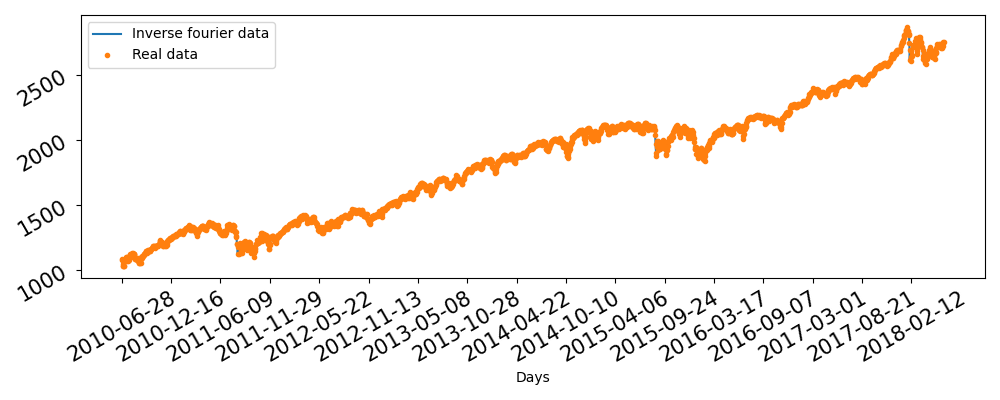

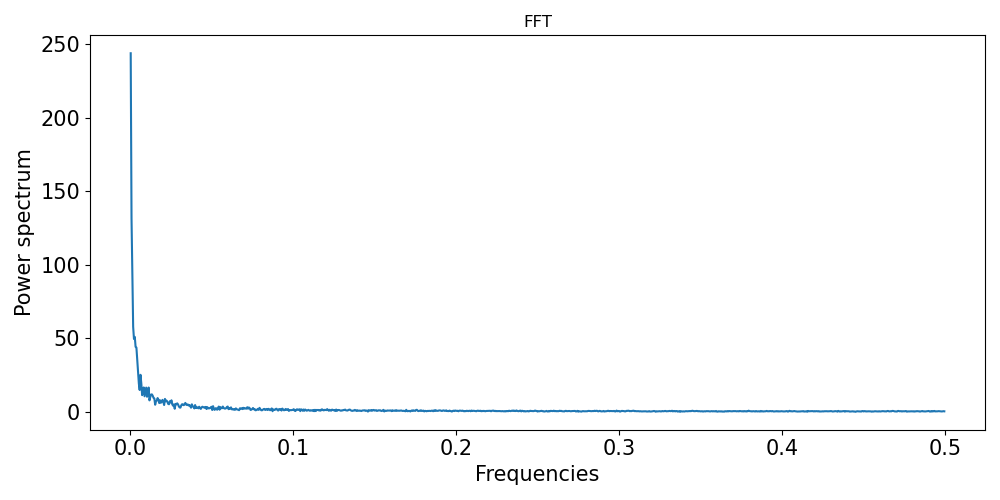

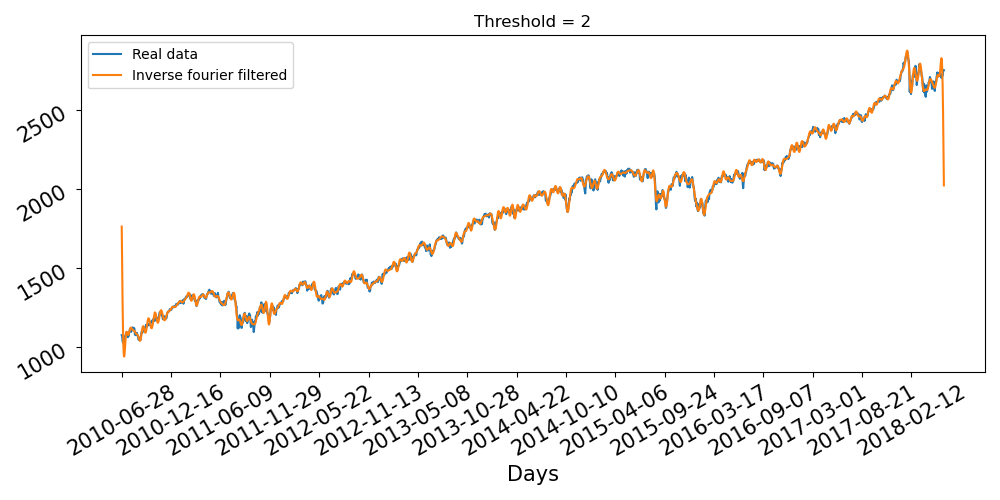

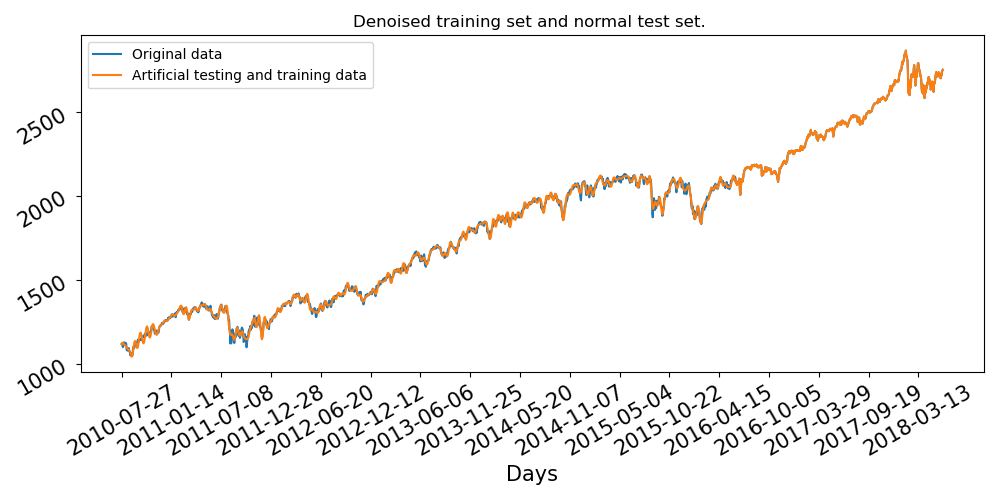

In [48]:
####################################################################################
# apply discrete fourier transform
####################################################################################
df = pd.read_csv('./test_data/GSPC.csv')
signal = np.array(df['Open'][time_series_segment:]) # data
fft_coefficients = fft(signal) # fourier transform
fft_coefficients

# plot orignal signal and inverse fourier transform, shows you can transform signal to frequency domain, then back to time domain
inverse_fft = ifft(fft_coefficients)
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(df['Date'][time_series_segment:],inverse_fft,'-',label='Inverse fourier data')
ax.plot(range(0,len(inverse_fft)),signal,'.',label='Real data')
ax.set_xlabel('Days')
ax.set_xticks([df['Date'][time_series_segment:].iloc[x] for x in range(0,len(df['Date'][time_series_segment:]),120)])
ax.legend()
ax.tick_params(rotation=30,labelsize=15)
plt.tight_layout()

# plot amplitude vs frequency 
n = len(signal)

# get frequencies and psd
freqs = fftfreq(signal.shape[0]) # x axis of amplitude vs frequency graphs
psd = np.abs(fft_coefficients)/n # psd is amplitude/N, psd or power spectrum density is the magnitude of the coefficients resulting from fourier transform

# plot psd
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(freqs[1:int(n/2)],psd[1:int(n/2)])
ax.set_ylabel('Power spectrum',fontsize=15)
ax.set_xlabel('Frequencies',fontsize=15)
ax.set_title('FFT')
ax.tick_params(labelsize=15)
plt.tight_layout()

####################################################################################
# denoise using one of two stragies; low-pass filter, amplitude filter
####################################################################################

if filtering_methods == 'amplitude':
    # filter by coefficient amplitude
    # Threshold coefficients to denoise signal
    psd_indices = psd > threshold# 0.06 # mask
    fft_filtered = fft_coefficients*psd_indices

elif filtering_methods == 'low-pass':
    # low pass filtering
    freq_indices = freqs < threshold
    fft_filtered = fft_coefficients*freq_indices

# inverse transform filter coefficients
inverse_transform_filtered = ifft(fft_filtered)

# plot this
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'][time_series_segment:],signal,'-',label='Real data')
ax.plot(df['Date'][time_series_segment:],inverse_transform_filtered,'-',label='Inverse fourier filtered')
ax.legend()
ax.set_title(f"Threshold = {threshold}")
ax.set_xlabel('Days',fontsize=15)
ax.set_xticks([df['Date'][time_series_segment:].iloc[x] for x in range(0,len(df['Date'][time_series_segment:]),120)])
ax.tick_params(rotation=30,labelsize=15)

plt.tight_layout()

####################################################################################
# put together artifical data, here the training set is denoised and the testing set is left unchanged
####################################################################################

df_data = pd.DataFrame(columns=['Date','original_data','artificial_data'])
df_data['Date'] = df['Date'][time_series_segment+first_timestep:]
df_data['original_data'] = df['Open'][time_series_segment+first_timestep:]
df_data['artificial_data'] = np.concatenate((np.real(inverse_transform_filtered)[time_series_segment+first_timestep:-500],df['Open'][-500:].to_numpy()),axis=None)

# plot artifical / denoised training + normal testing set
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df_data['Date'],df_data['original_data'],'-',label='Original data')
#ax.plot(df['Date'][time_series_segment+first_timestep:],df['Open'][time_series_segment+first_timestep:],'-',label='Real data')
ax.plot(df_data['Date'],df_data['artificial_data'],'-',label='Artificial testing and training data')
ax.legend()
ax.set_title(f"Denoised training set and normal test set. ")
ax.set_xlabel('Days',fontsize=15)
ax.set_xticks([df_data['Date'][time_series_segment+first_timestep:].iloc[x] for x in range(0,len(df_data['Date'][time_series_segment+first_timestep:]),120)])
ax.tick_params(rotation=30,labelsize=15)

plt.tight_layout()

# testing environment

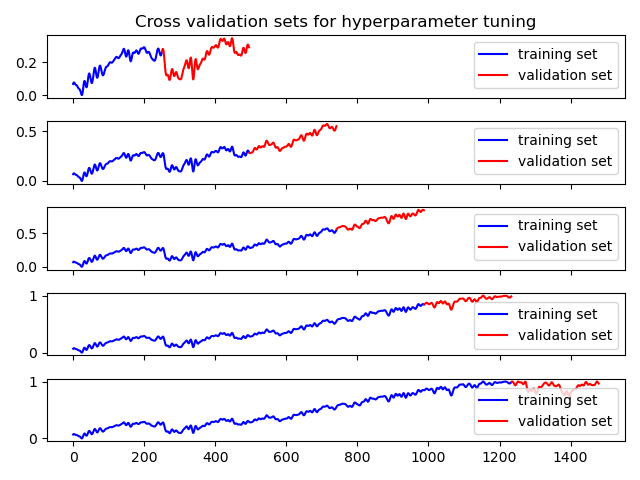


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04478799503926477
best_model:  MLPRegressor(hidden_layer_sizes=(500,), learning_rate='adaptive',
             learning_rate_init=0.01, max_iter=5000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
MAPE: 0.054544106570221074
RMSE:  0.08390547568481371
MAE:  0.07112329728183933


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.522088  1.536591
1976  2018-06-01  1.551646    NaN  1.481986   1.52357  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.524567  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.525538    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.527518  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 51.05 %
Confusion matrix:
[[386 185]
 [466 293]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


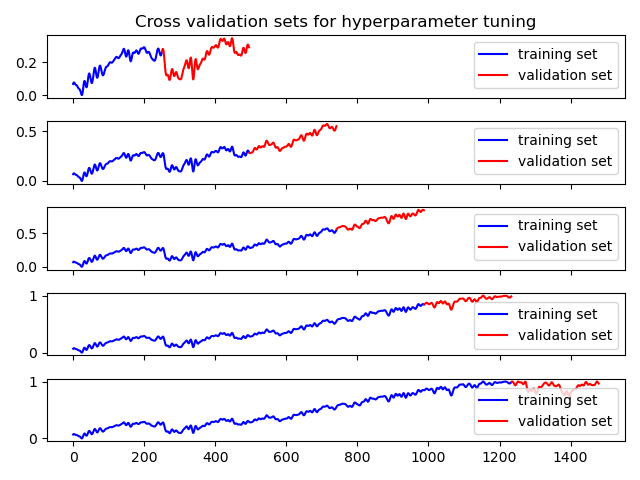


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04896761180216188
best_model:  MLPRegressor(activation='tanh', hidden_layer_sizes=(500,), max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'tanh', 'hidden_layer_sizes': (500,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
MAPE: 0.12238456325523372
RMSE:  0.19706503177799
MAE:  0.1681876786162407


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.233071  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.230059  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.224221  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.218291    1.5729
1979  2018-06-06  1.583615    NaN  1.490917   1.21285  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 47.89 %
Confusion matrix:
[[462 109]
 [584 175]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


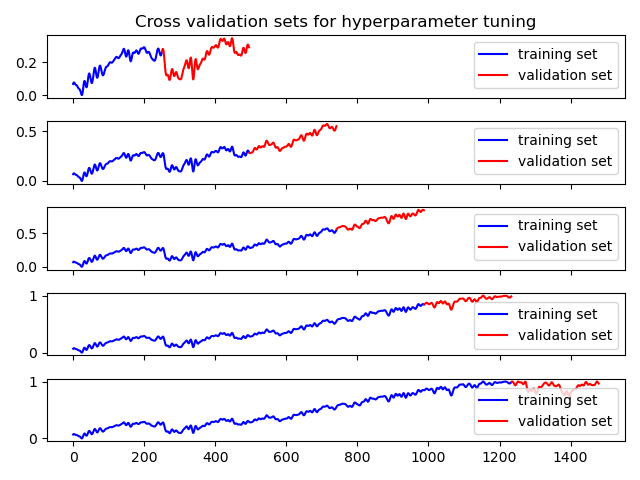


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04731727062083134
best_model:  MLPRegressor(hidden_layer_sizes=(1000,), learning_rate='invscaling',
             learning_rate_init=0.01, max_iter=5000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01}
MAPE: 0.11703552940514425
RMSE:  0.15744083223708621
MAE:  0.14862233501538552


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.459786  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.460135  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.461293  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.462204    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.462938  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 50.53 %
Confusion matrix:
[[390 181]
 [477 282]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


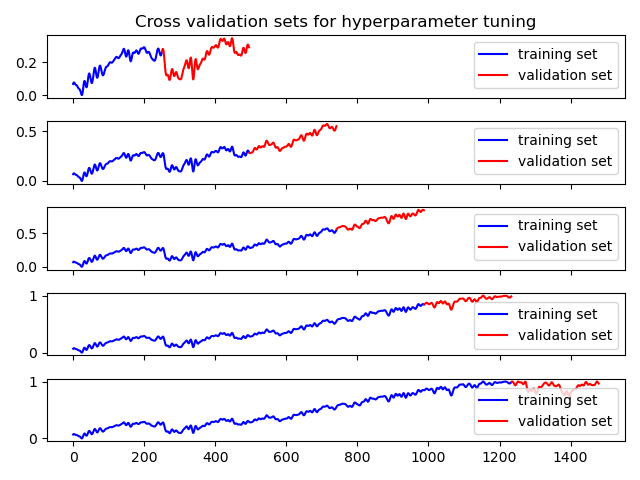


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.044849263669691025
best_model:  MLPRegressor(hidden_layer_sizes=(500,), learning_rate='adaptive', max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
MAPE: 0.029973928532522044
RMSE:  0.05240221056615609
MAE:  0.03914413961032842


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.632743  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.639973  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.640514  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.623825    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.629488  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 47.59 %
Confusion matrix:
[[448 123]
 [574 185]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


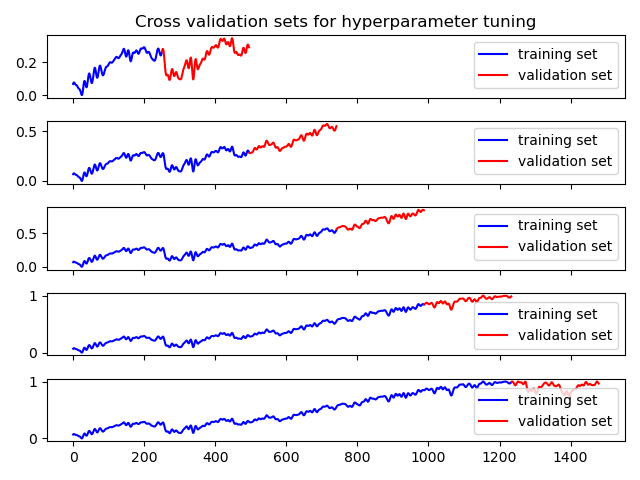


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04797522535467343
best_model:  MLPRegressor(activation='tanh', hidden_layer_sizes=(500,),
             learning_rate='invscaling', max_iter=5000, shuffle=False)
best_params:  {'activation': 'tanh', 'hidden_layer_sizes': (500,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
MAPE: 0.12309065532676196
RMSE:  0.2021131939102189
MAE:  0.169990760805928


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015   1.21858  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.214606  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.214785  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.209227    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.208076  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 46.69 %
Confusion matrix:
[[456 115]
 [594 165]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


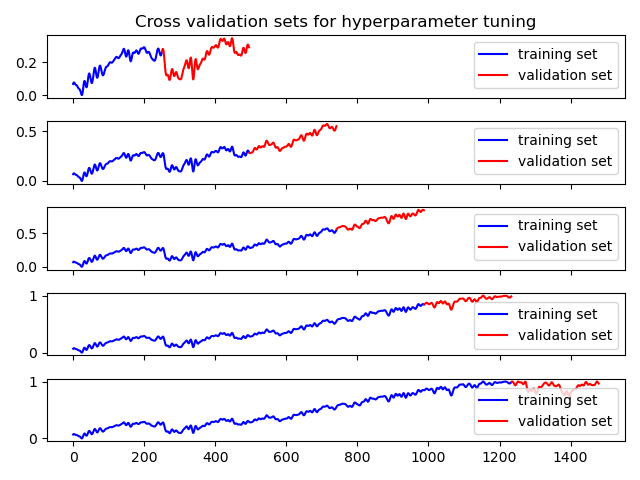


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.05090046173770306
best_model:  MLPRegressor(hidden_layer_sizes=(500,), learning_rate_init=0.01, max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
MAPE: 0.03709353933171118
RMSE:  0.06634990020148558
MAE:  0.04865666171856946


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.691719  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.690966  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.691749  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.693329    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.694219  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 50.53 %
Confusion matrix:
[[386 185]
 [473 286]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


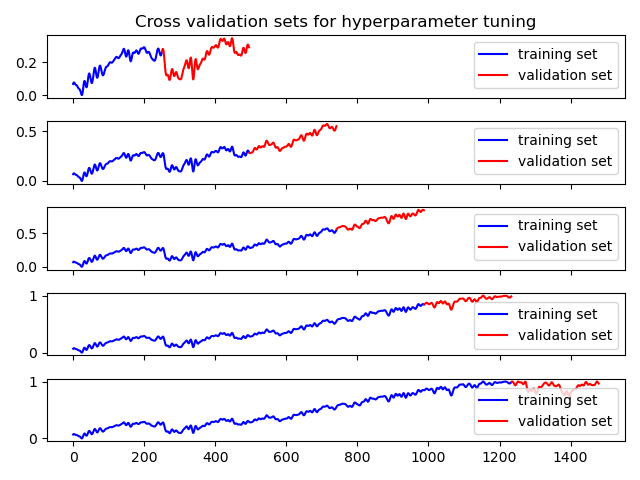


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.05065122500873429
best_model:  MLPRegressor(hidden_layer_sizes=(500,), learning_rate='adaptive',
             learning_rate_init=0.01, max_iter=5000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
MAPE: 0.04820984677343583
RMSE:  0.07514030480193469
MAE:  0.06330517861278127


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.512336  1.536591
1976  2018-06-01  1.551646    NaN  1.481986   1.51216  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.513213  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.514916    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.514977  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 50.38 %
Confusion matrix:
[[401 170]
 [490 269]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


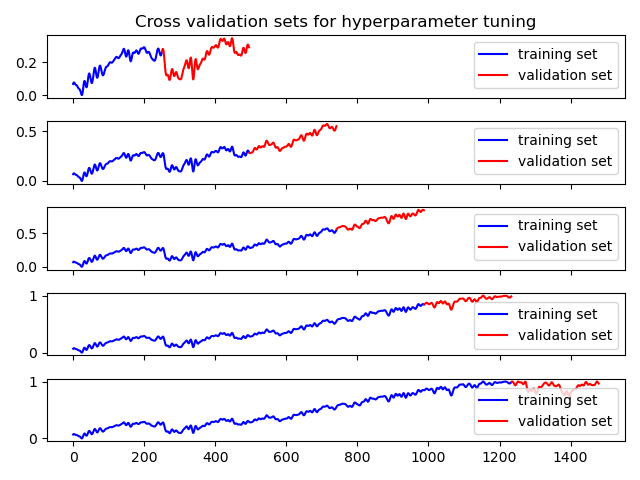


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.05049174542544447
best_model:  MLPRegressor(hidden_layer_sizes=(1000,), learning_rate='adaptive',
             max_iter=5000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
MAPE: 0.038746321688605305
RMSE:  0.061335173811901594
MAE:  0.05026855249209047


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.545205  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.538539  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.544189  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.539541    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.539012  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 47.59 %
Confusion matrix:
[[435 136]
 [561 198]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


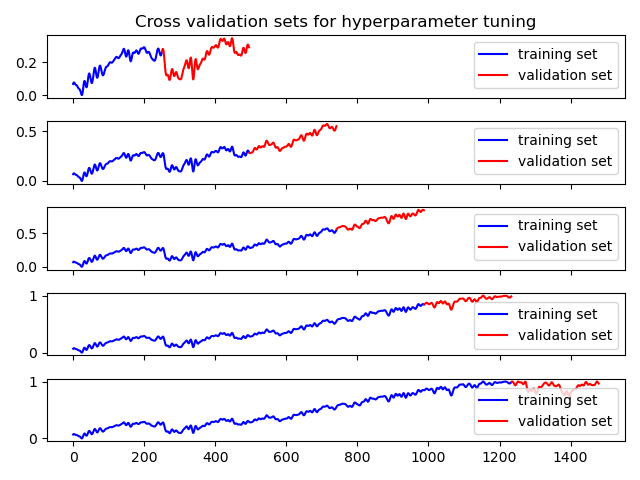


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04653274903662875
best_model:  MLPRegressor(activation='tanh', hidden_layer_sizes=(1000,),
             learning_rate='invscaling', max_iter=5000, shuffle=False)
best_params:  {'activation': 'tanh', 'hidden_layer_sizes': (1000,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
MAPE: 0.1412631311202897
RMSE:  0.2191537282121272
MAE:  0.19217398874583483


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.242241  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.244481  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.248705  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.254462    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.251856  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 48.35 %
Confusion matrix:
[[455 116]
 [571 188]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


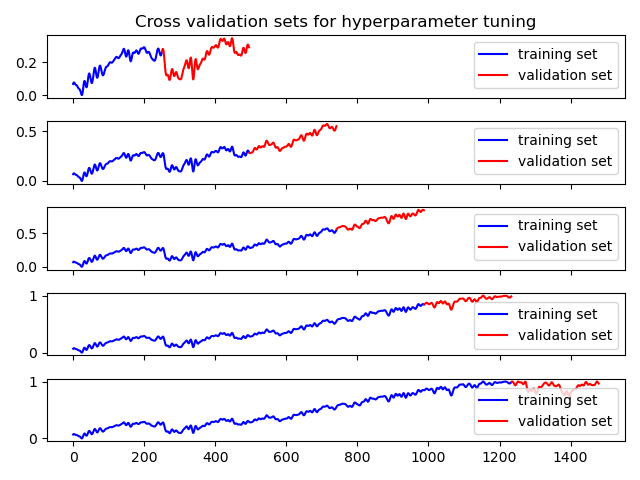


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.046135075419080275
best_model:  MLPRegressor(activation='logistic', learning_rate='invscaling', max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
MAPE: 0.09104156720191045
RMSE:  0.1490883848986976
MAE:  0.1253006290676197


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.337176  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.333796  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.332462  1.551646
1978  2018-06-05  1.579183    NaN  1.487335   1.33302    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.336318  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 50.23 %
Confusion matrix:
[[428 143]
 [519 240]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


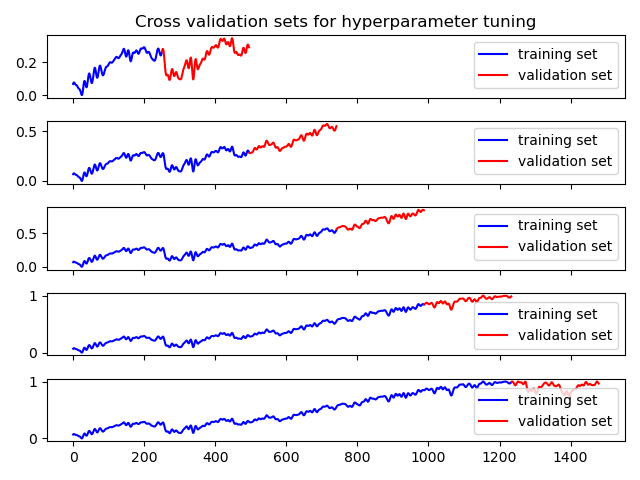


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04665811919543843
best_model:  MLPRegressor(hidden_layer_sizes=(1000,), learning_rate_init=0.01, max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
MAPE: 0.08864947112433066
RMSE:  0.12403798918800303
MAE:  0.11196760233460144


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.764831  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.766493  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.766629  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.768631    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.769935  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 50.68 %
Confusion matrix:
[[385 186]
 [470 289]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


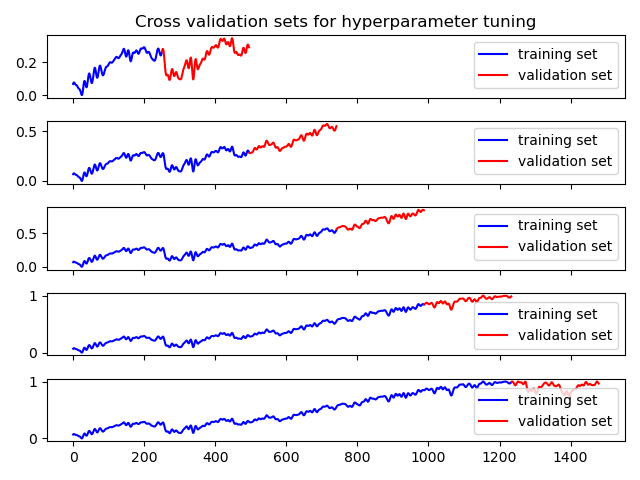


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04811042003115688
best_model:  MLPRegressor(activation='tanh', hidden_layer_sizes=(500,), max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'tanh', 'hidden_layer_sizes': (500,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
MAPE: 0.14772214447821988
RMSE:  0.23913113211477607
MAE:  0.2033511954864602


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.135367  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.139212  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.137633  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.128558    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.131717  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 47.07 %
Confusion matrix:
[[461 110]
 [594 165]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


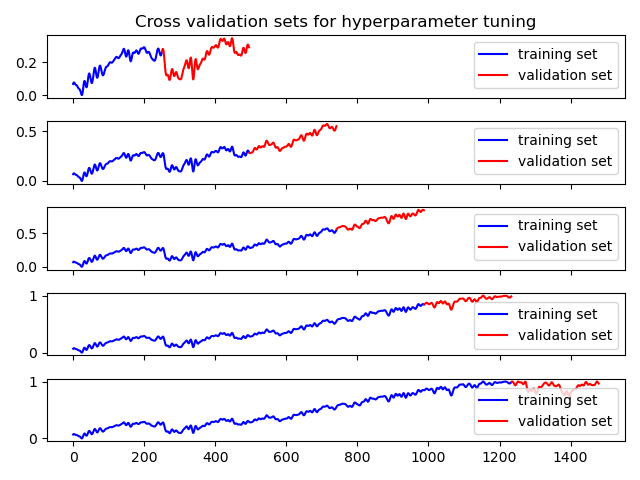


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04821736468584158
best_model:  MLPRegressor(activation='tanh', hidden_layer_sizes=(1000,), max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'tanh', 'hidden_layer_sizes': (1000,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
MAPE: 0.10789578196995062
RMSE:  0.17626673063992457
MAE:  0.14878019443556406


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.262487  1.536591
1976  2018-06-01  1.551646    NaN  1.481986   1.26258  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.267086  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.262044    1.5729
1979  2018-06-06  1.583615    NaN  1.490917   1.25623  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 46.84 %
Confusion matrix:
[[458 113]
 [594 165]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


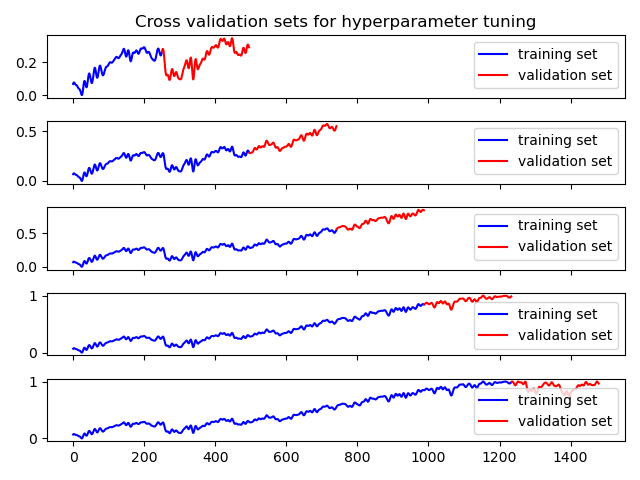


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.04744453306860506
best_model:  MLPRegressor(hidden_layer_sizes=(500,), learning_rate='invscaling',
             max_iter=5000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
MAPE: 0.5900437565856556
RMSE:  0.7676686753781129
MAE:  0.7567159732991544


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015   0.68305  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  0.689069  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  0.680875  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  0.683882    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  0.682065  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[470 101]
 [588 171]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


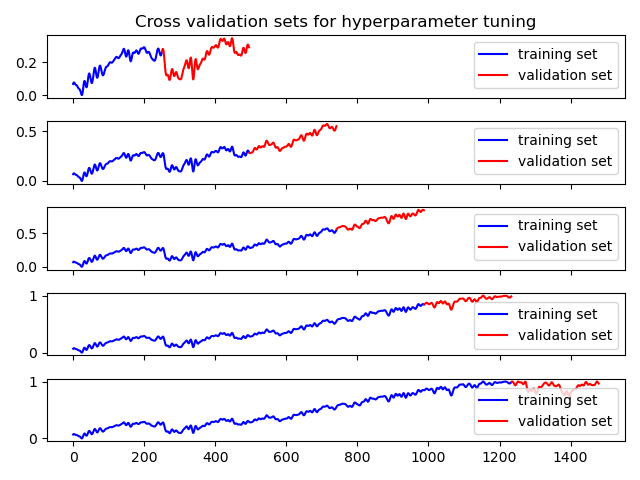


Naive model results:
MAPE: 0.007629888350451673
RMSE:  0.015442232931069026
MAE:  0.009846864547191988

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.08449012222214222
best_model:  SVR(C=0.1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.06162574522690558
RMSE:  0.08659587761638492
MAE:  0.0790294304266968

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.042840277959308795
best_model:  MLPRegressor(hidden_layer_sizes=(500,), learning_rate='invscaling',
             max_iter=5000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
MAPE: 0.036557745455071844
RMSE:  0.06051494388173424
MAE:  0.047714271287846985


date     Value Linear       SVM        NN     Naive
0     2010-07-27  0.067885    NaN      None      None      None
1     2010-07-28  0.074581    NaN      None      None      None
2     2010-07-29  0.077196    NaN      None      None      None
3     2010-07-30  0.076145    NaN      None      None      None
4     2010-08-02  0.072789    NaN      None      None      None
...          ...       ...    ...       ...       ...       ...
1975  2018-05-31  1.553755    NaN  1.480015  1.560787  1.536591
1976  2018-06-01  1.551646    NaN  1.481986  1.548502  1.553755
1977  2018-06-04  1.572900    NaN  1.484034  1.540258  1.551646
1978  2018-06-05  1.579183    NaN  1.487335  1.533621    1.5729
1979  2018-06-06  1.583615    NaN  1.490917  1.532213  1.579183

[1980 rows x 6 columns]

Linear Regression:
Movement prediction accuracy: 42.93 %
Confusion matrix:
[[571   0]
 [759   0]]
SVM:
Movement prediction accuracy: 50.0 %
Confusion matrix:
[[414 157]
 [508 251]]
NN:
Movement prediction accuracy: 48.57 %
Confusion matrix:
[[457 114]
 [570 189]]
Naive:
Movement prediction accuracy: 48.2 %
Confusion matrix:
[[454 117]
 [572 187]]


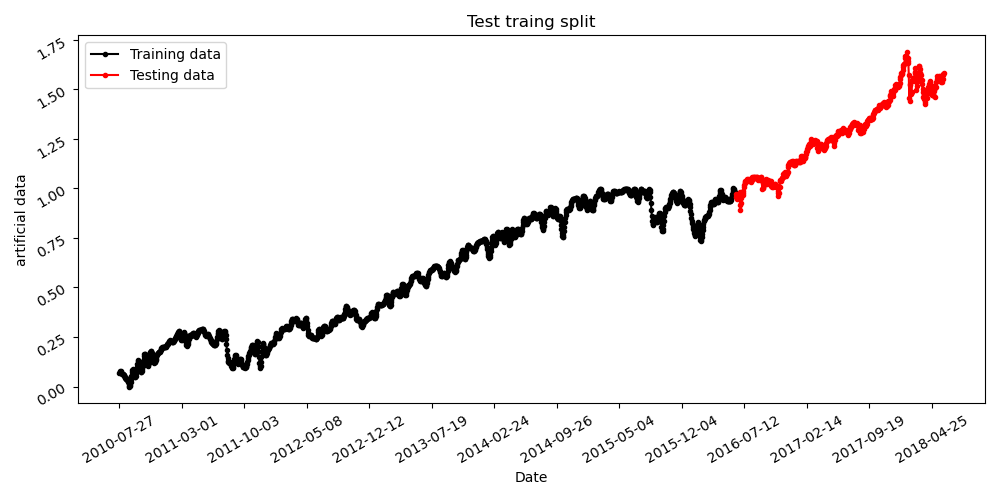

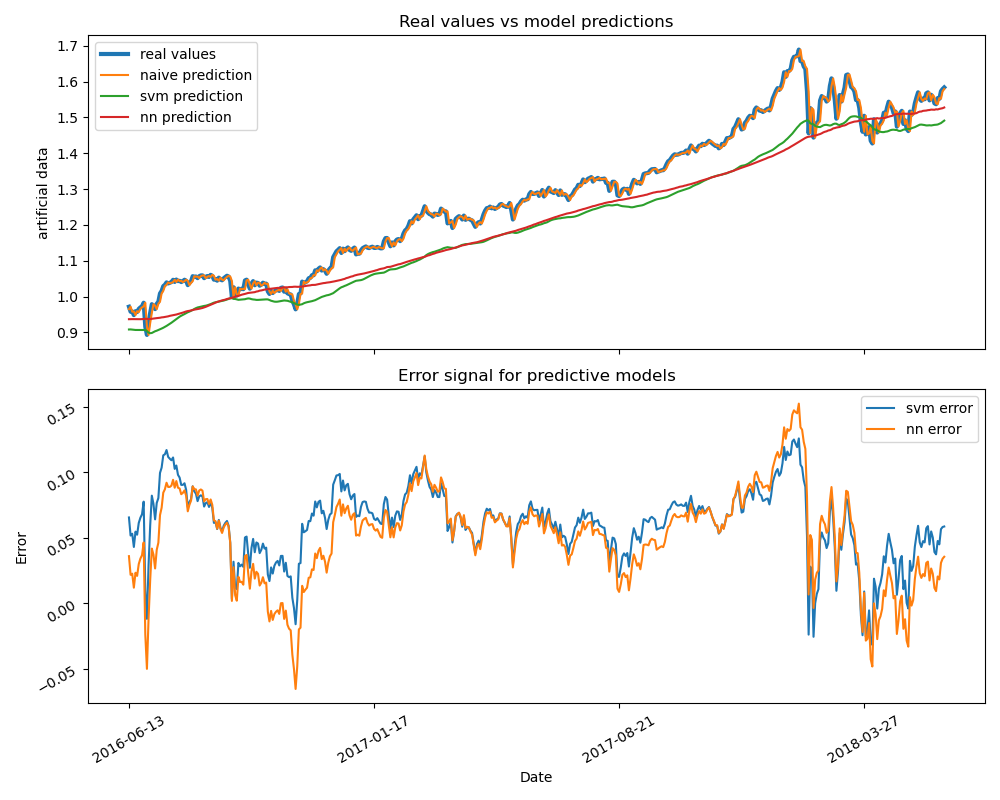

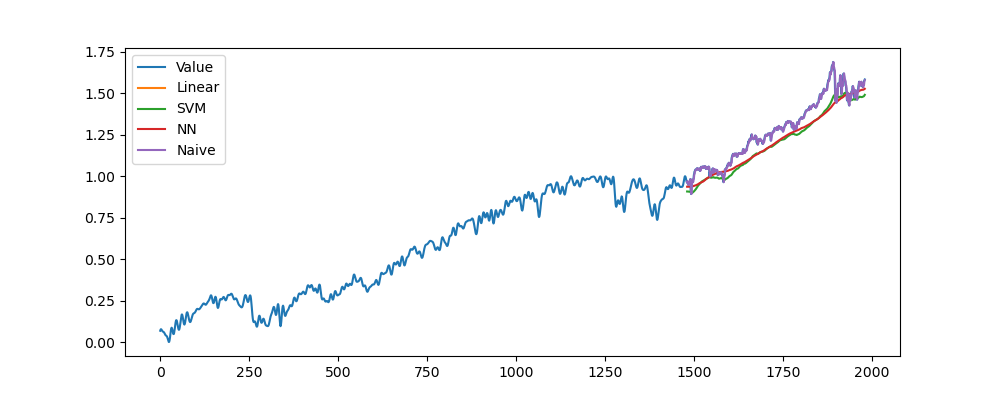

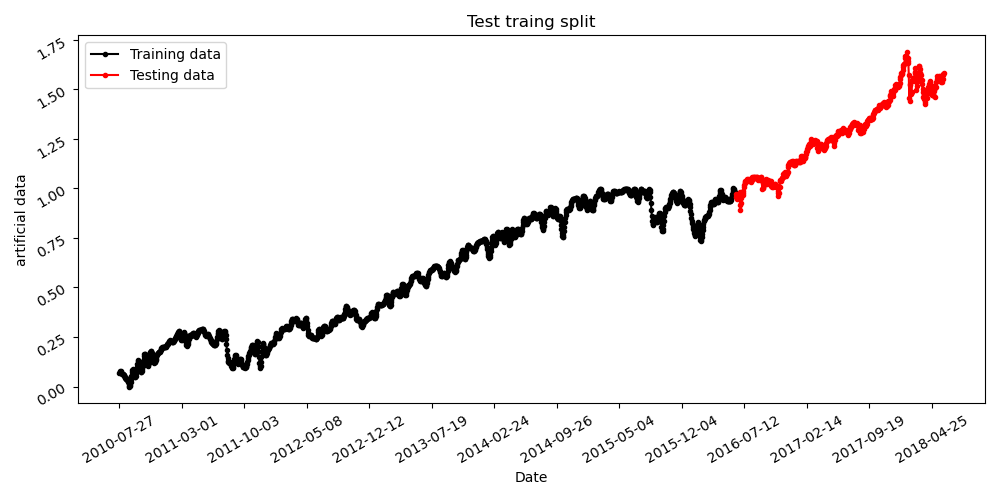

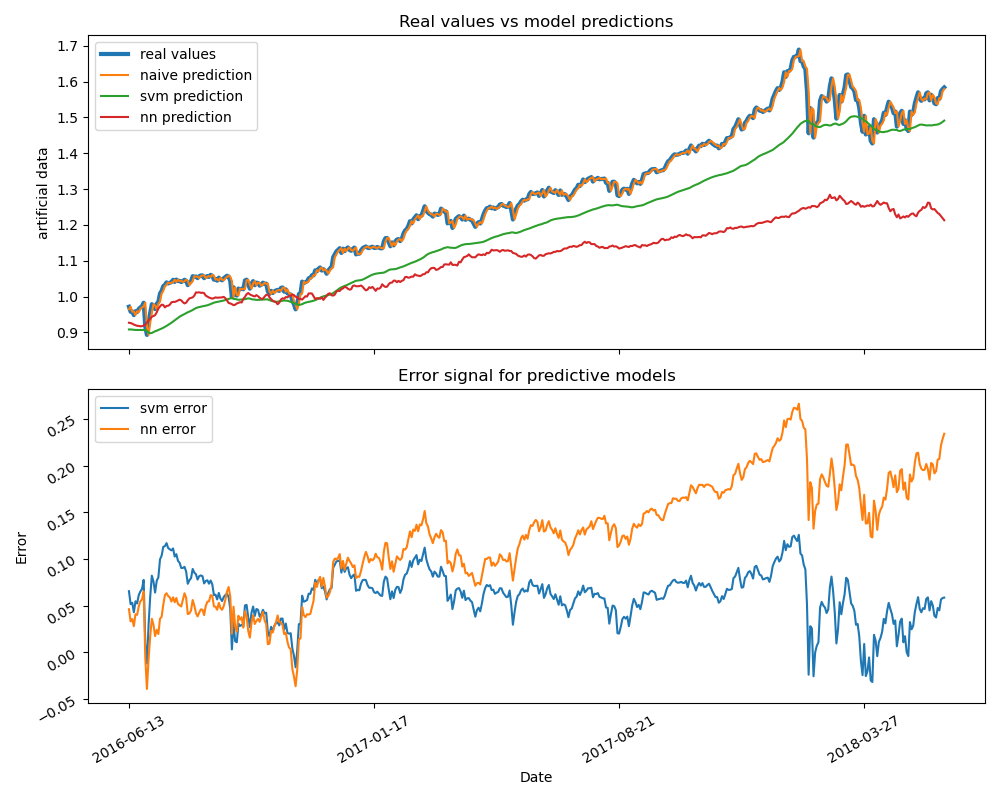

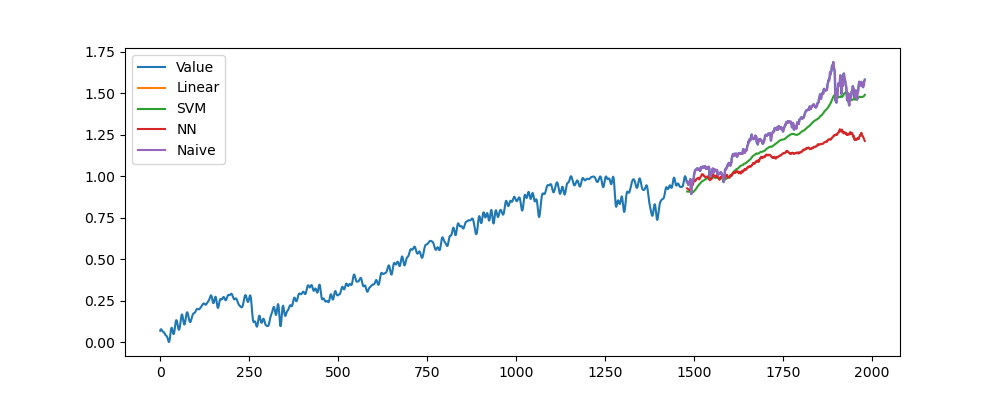

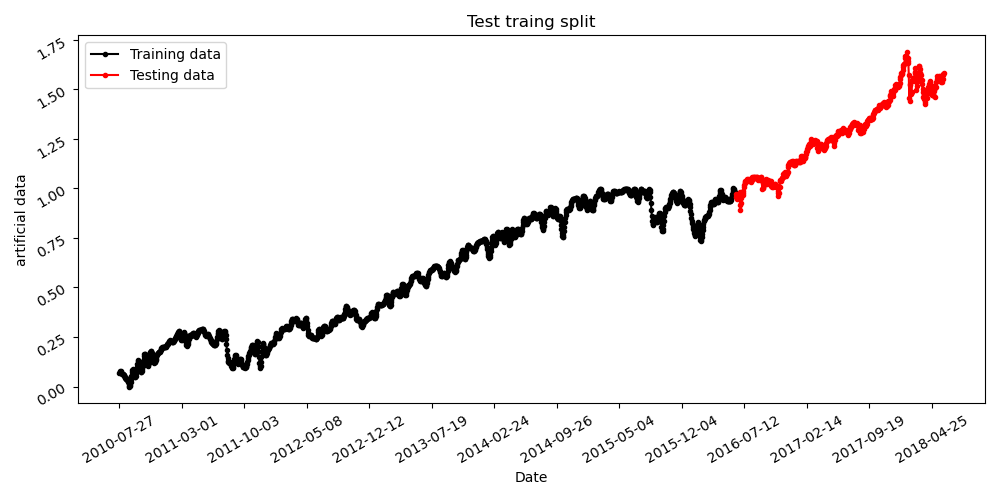

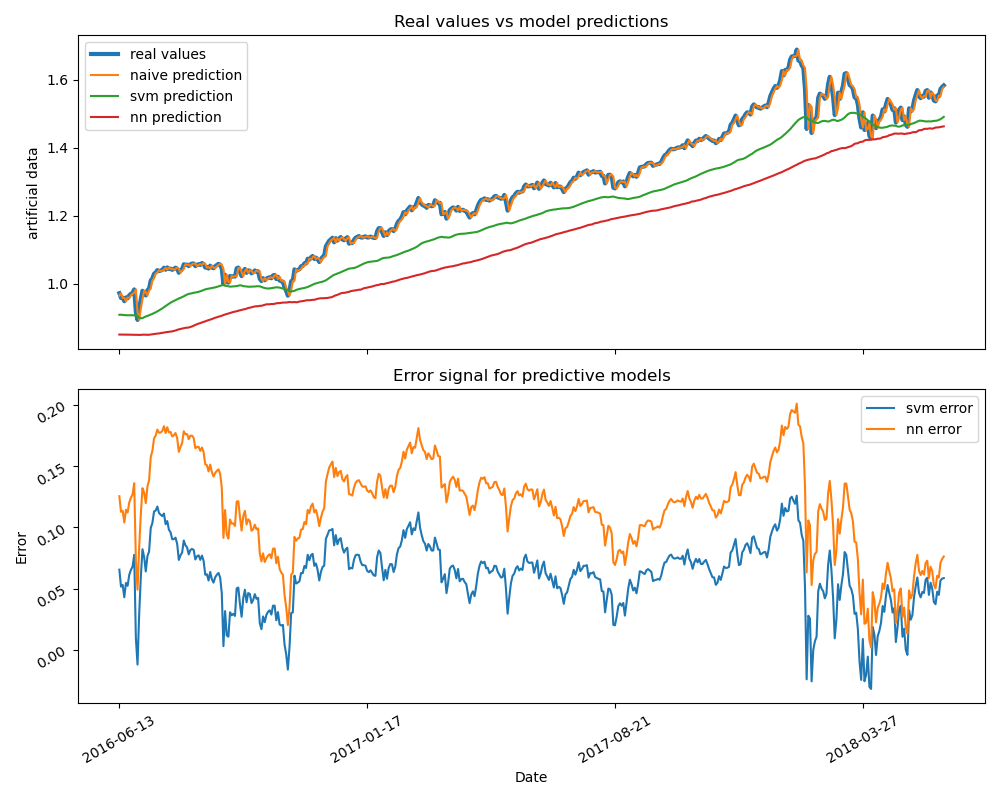

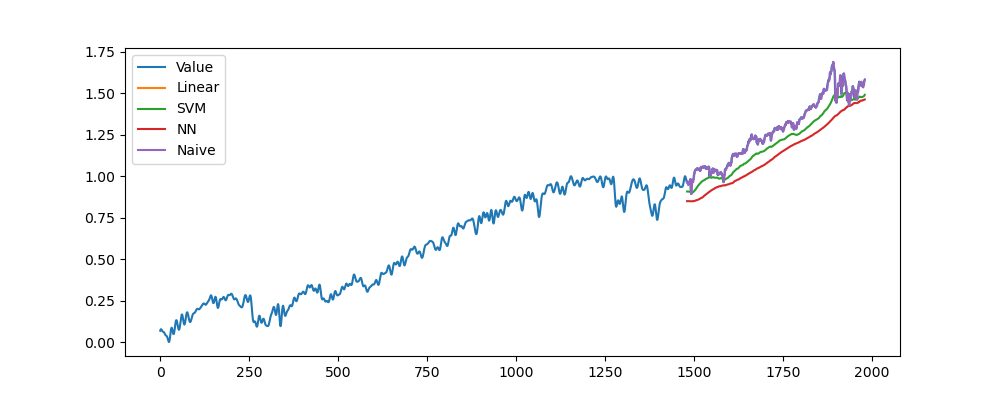

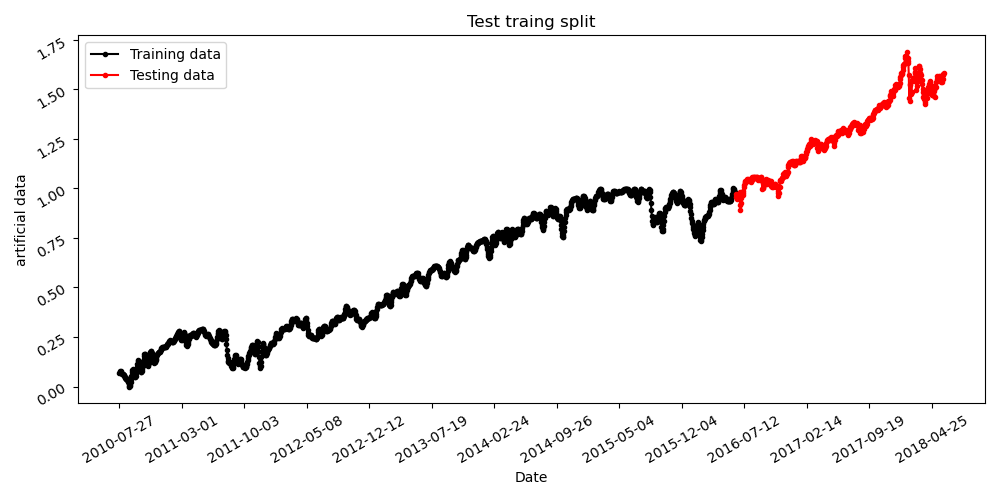

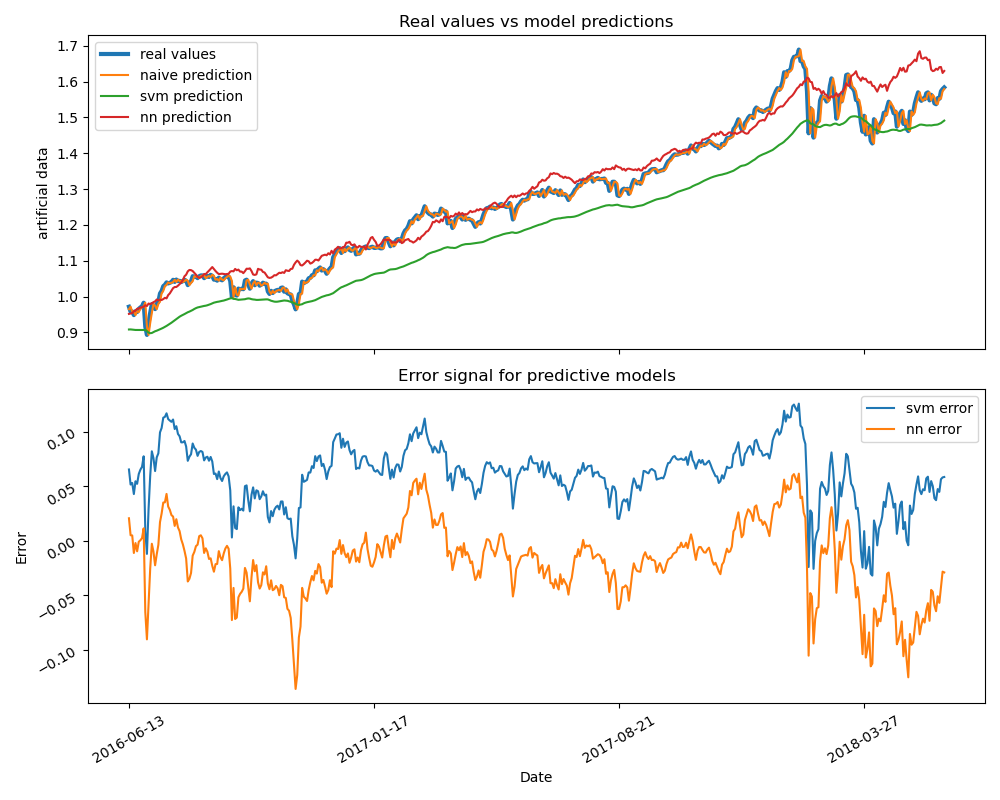

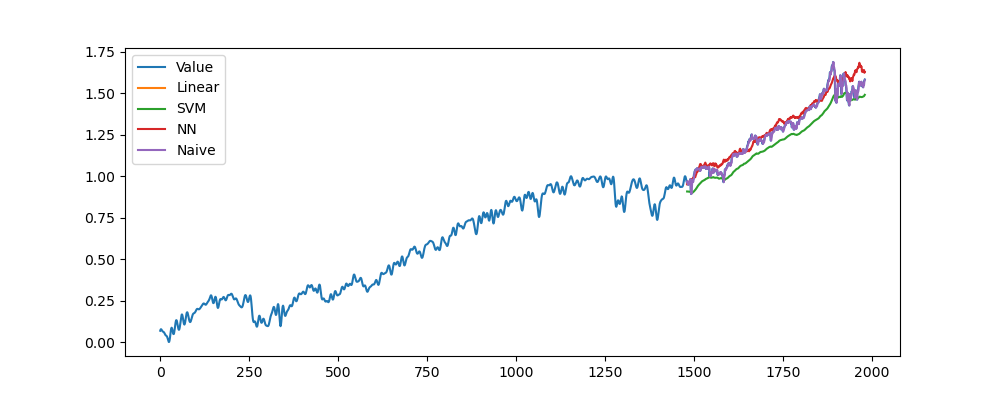

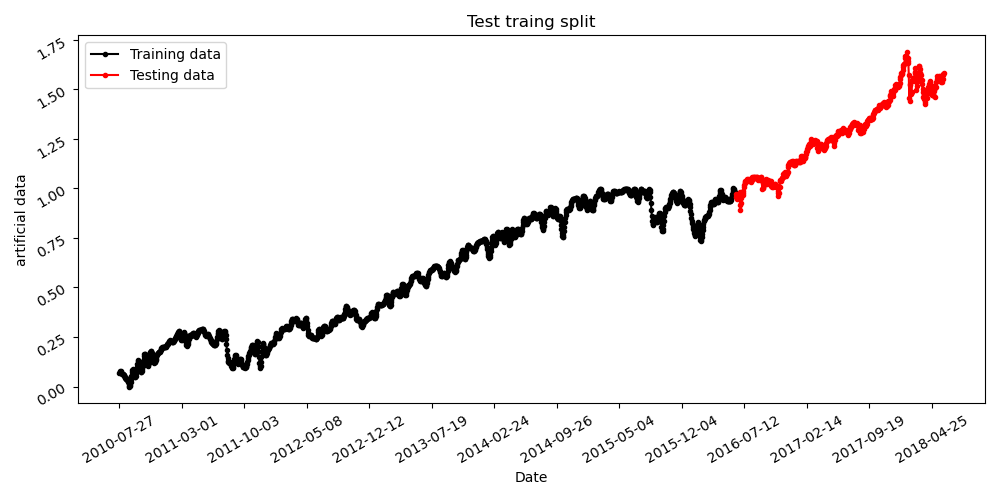

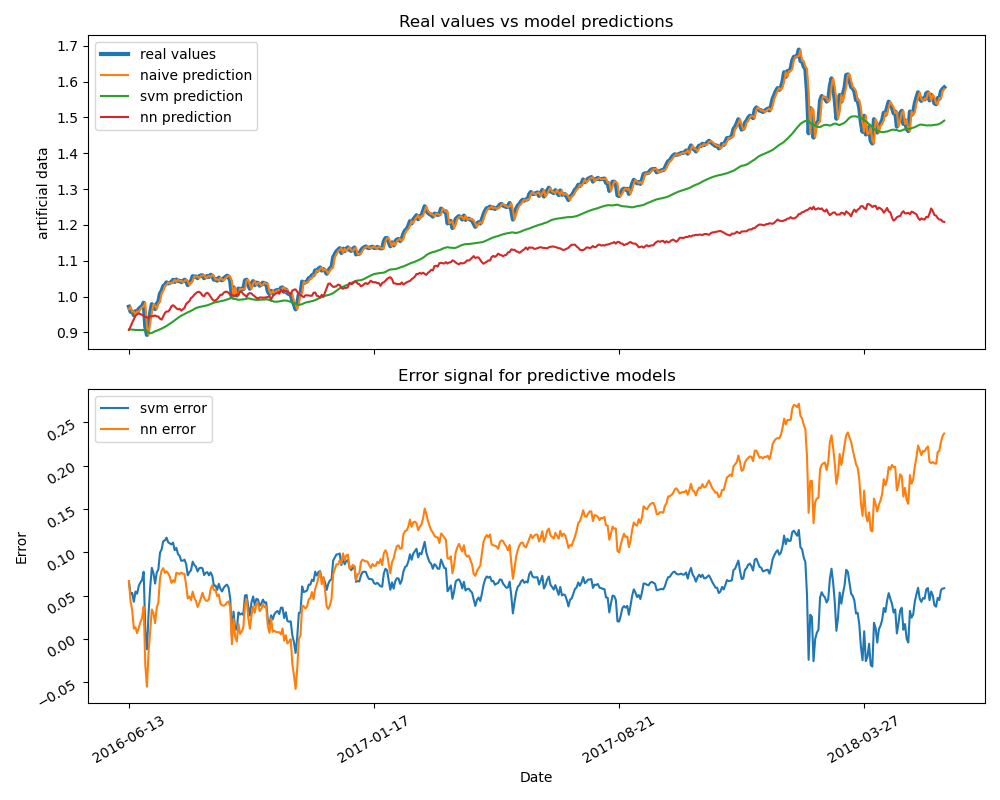

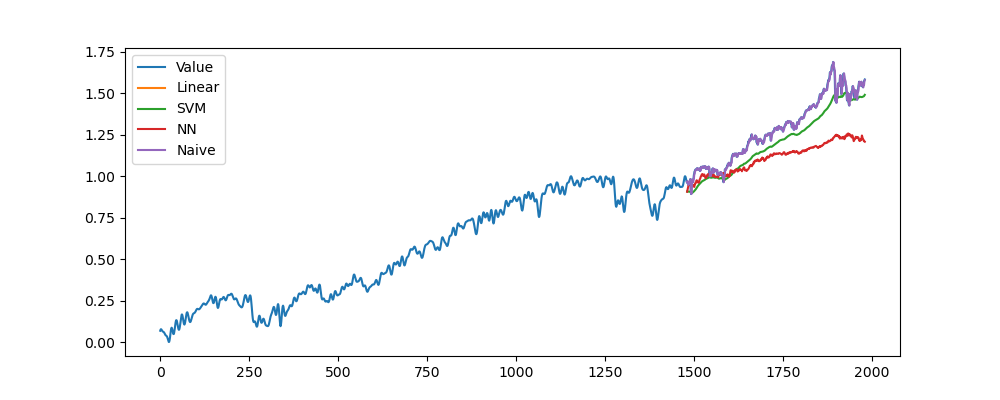

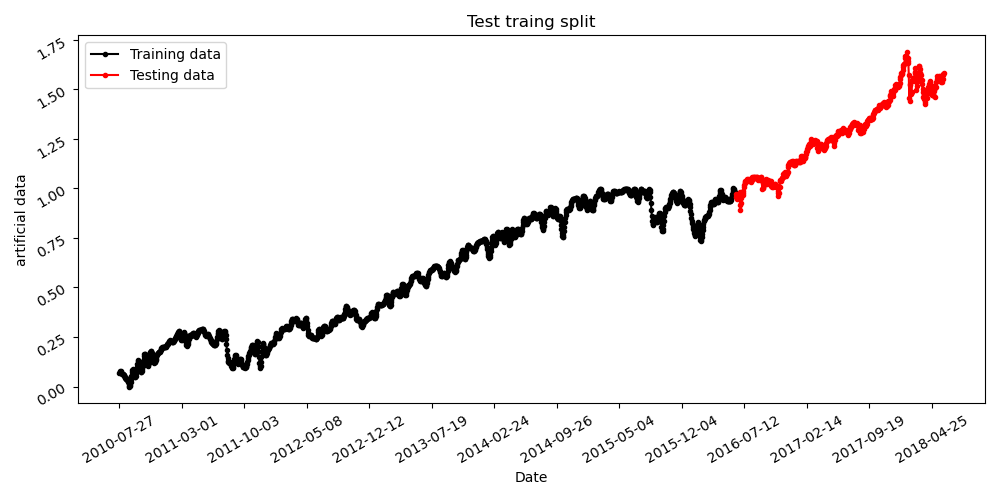

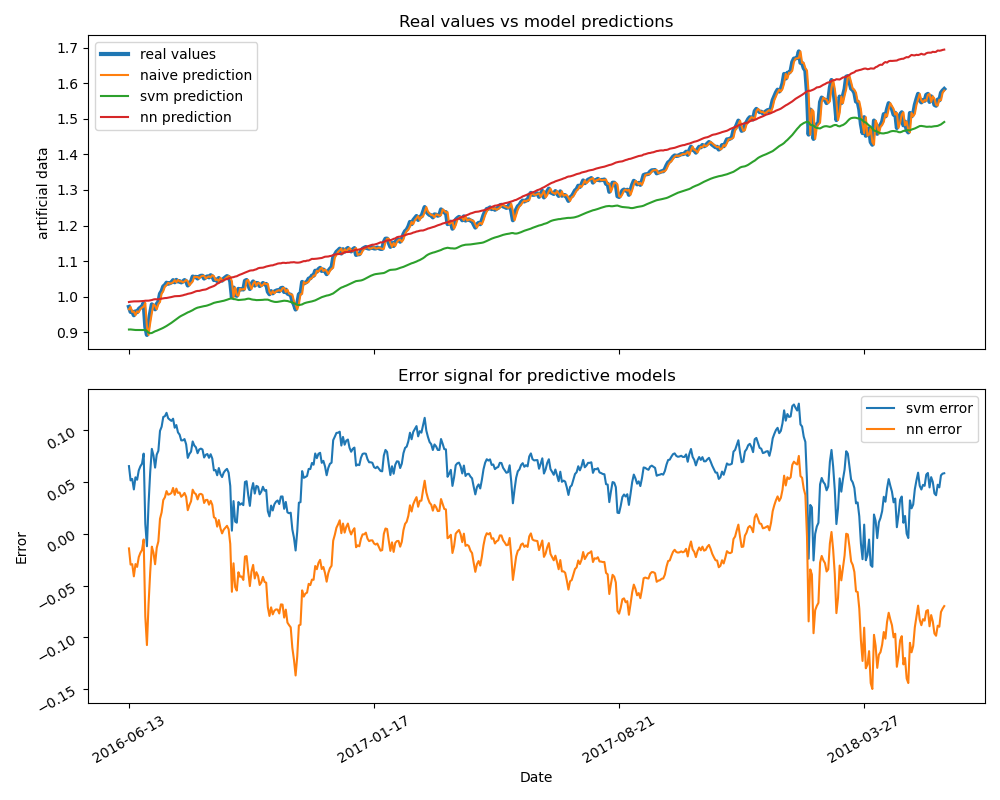

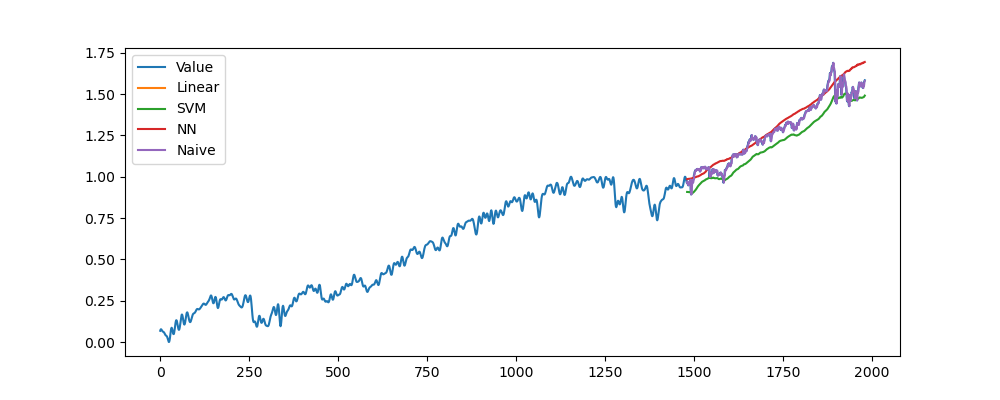

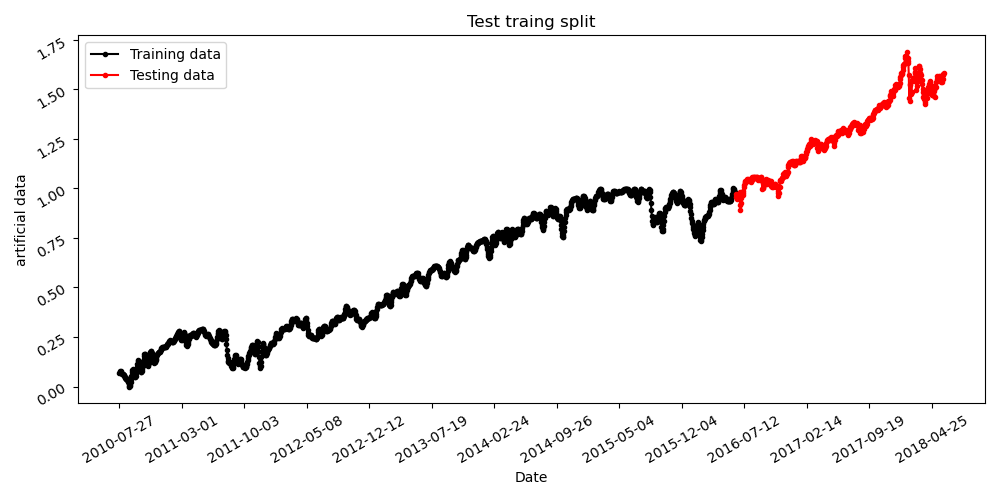

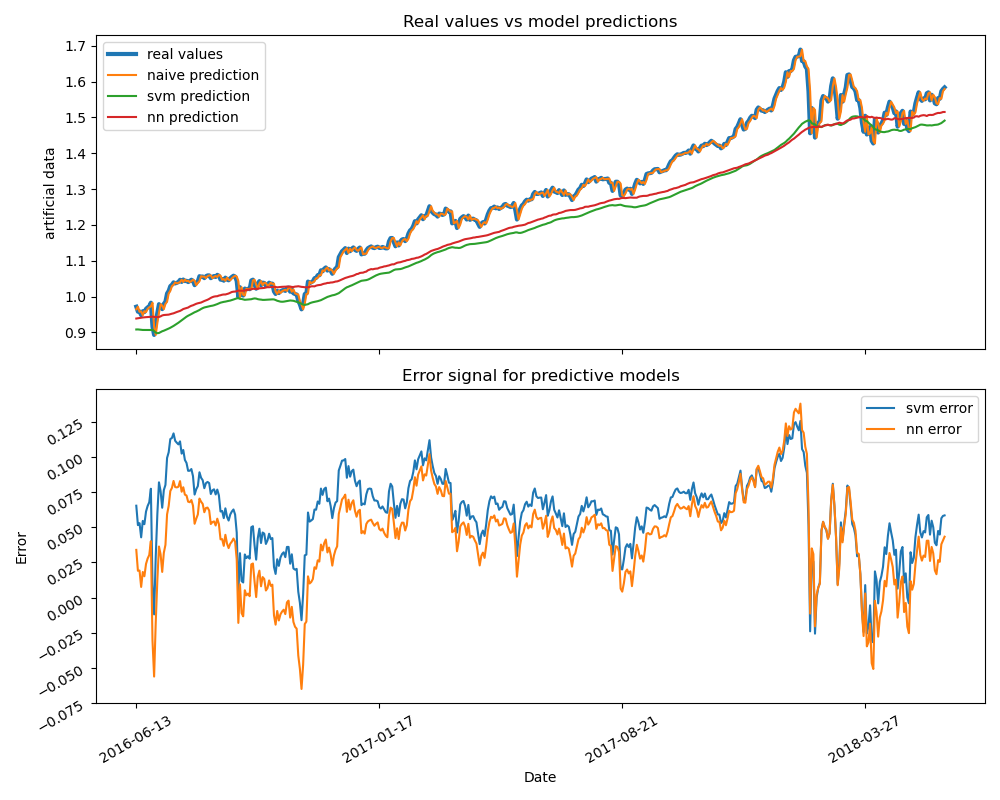

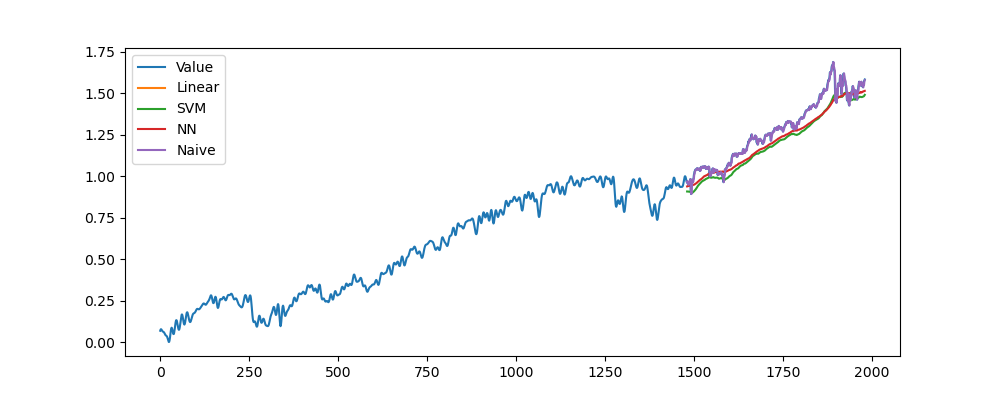

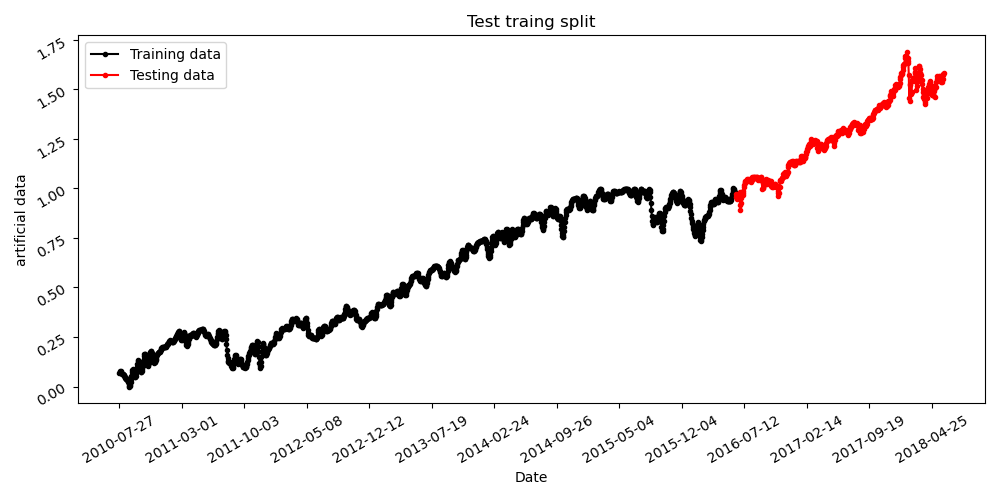

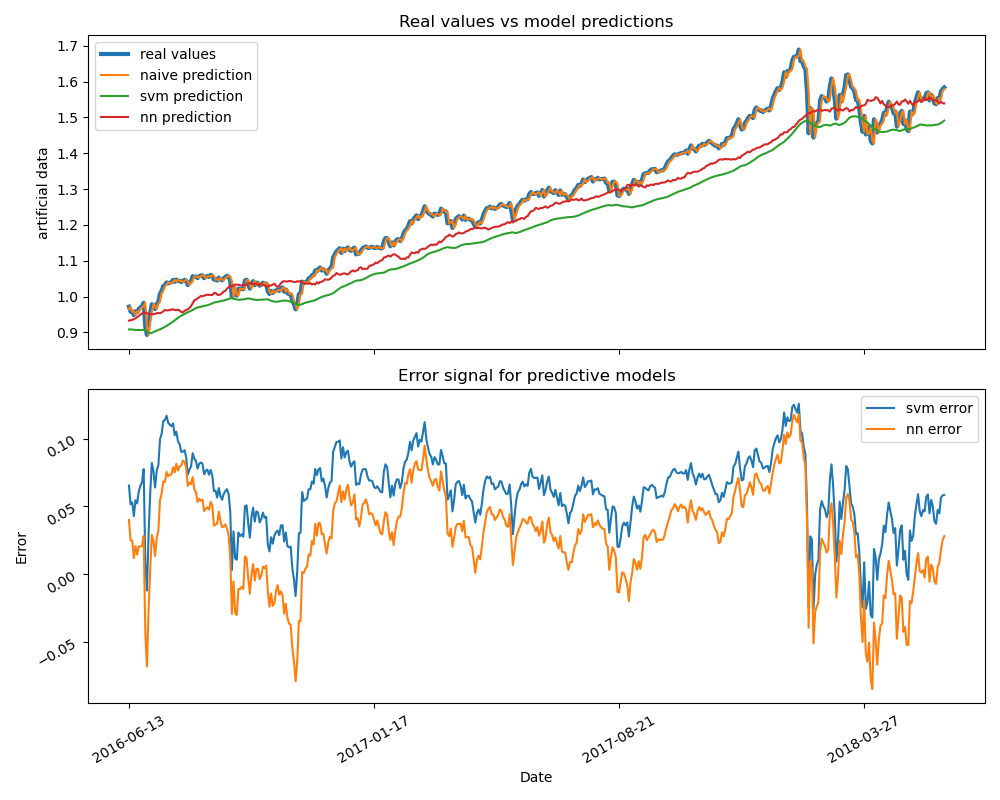

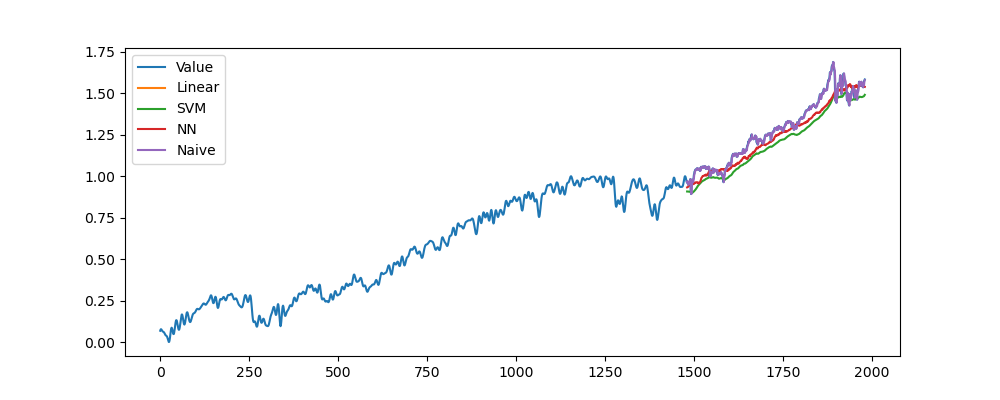

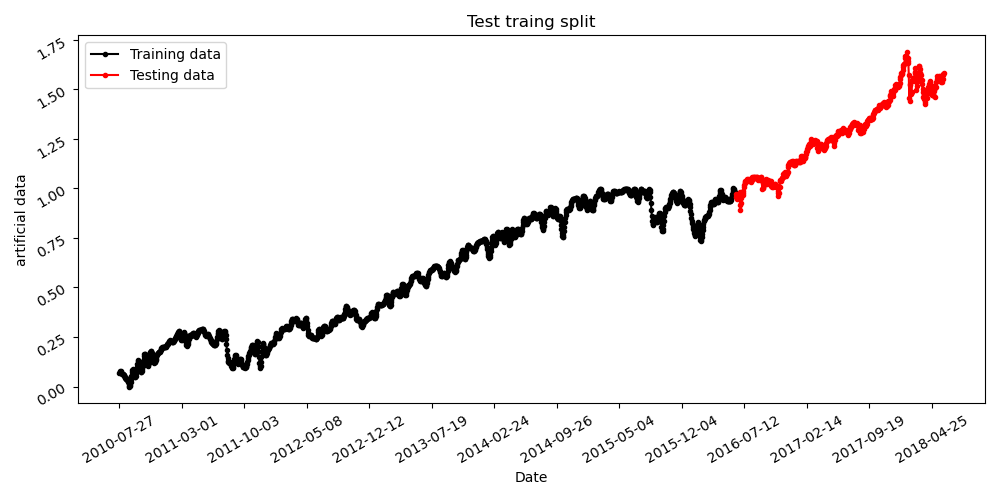

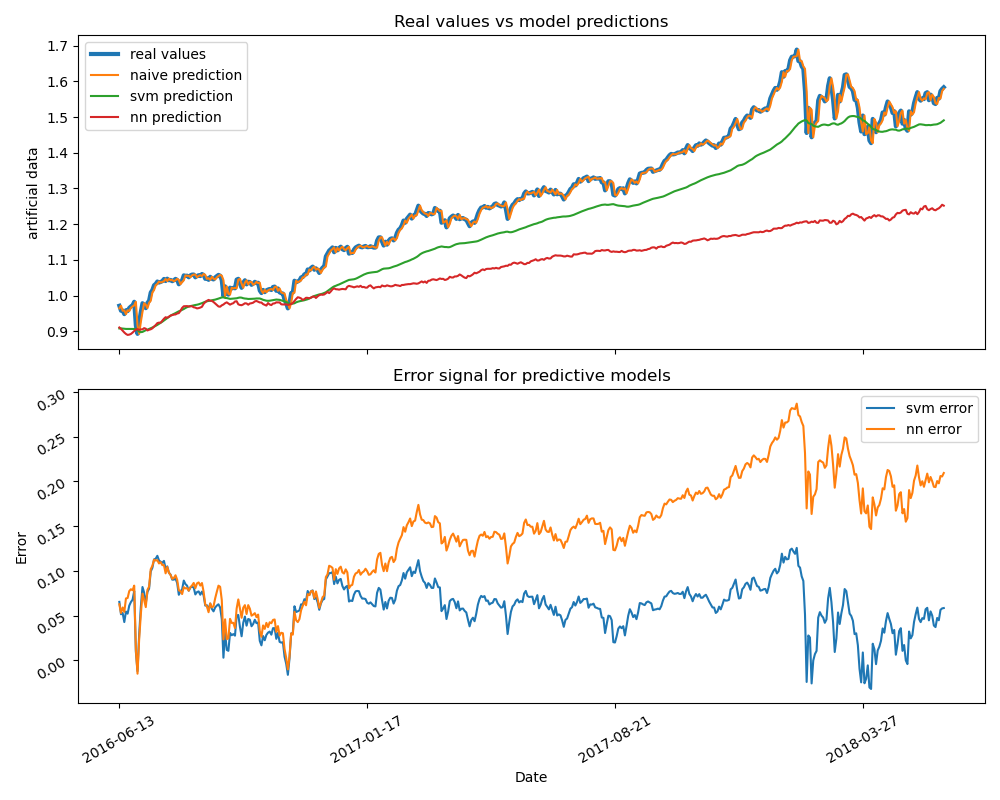

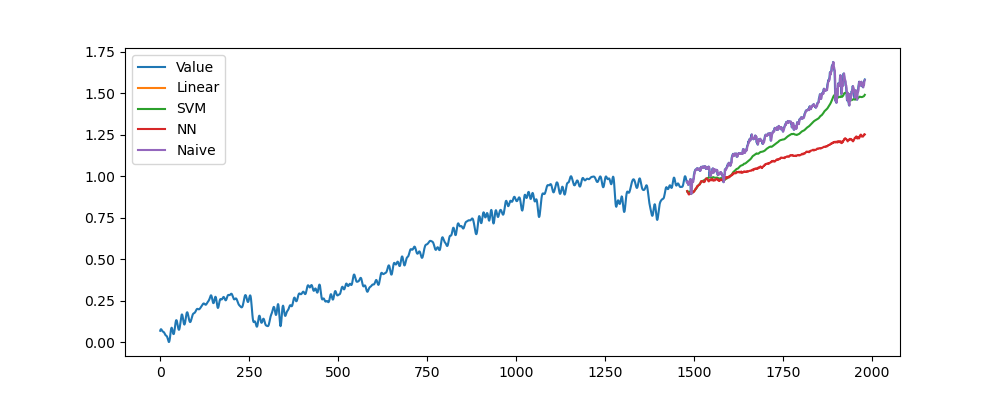

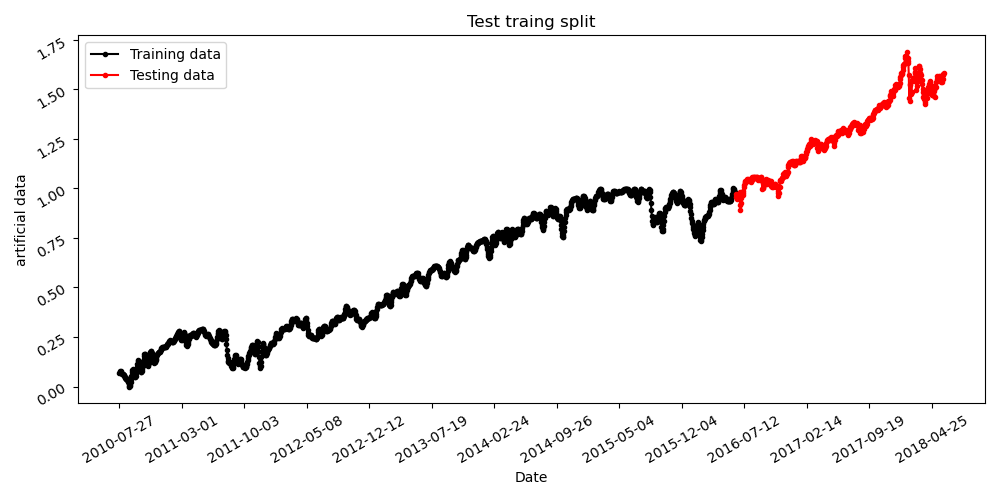

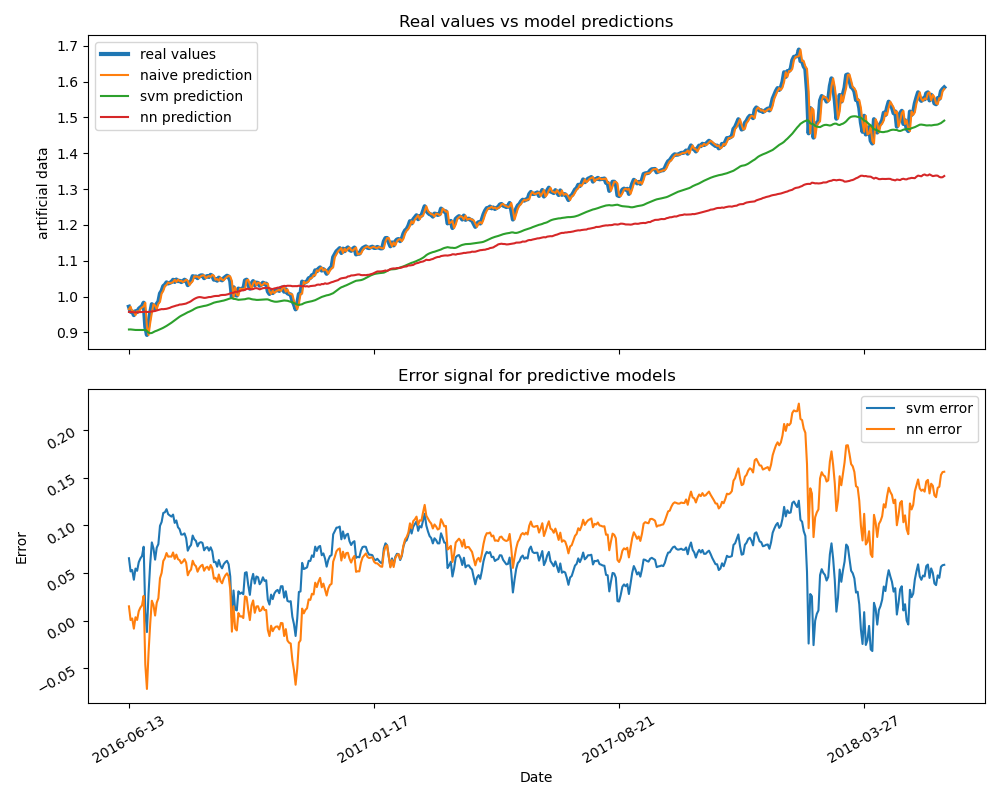

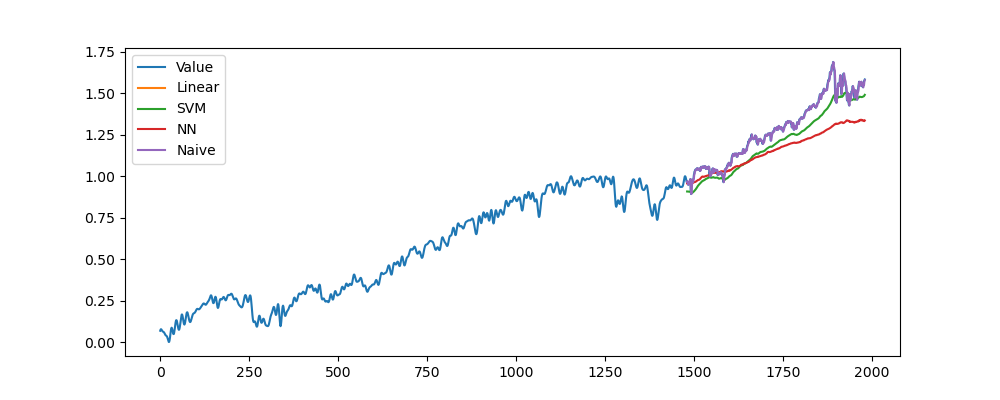

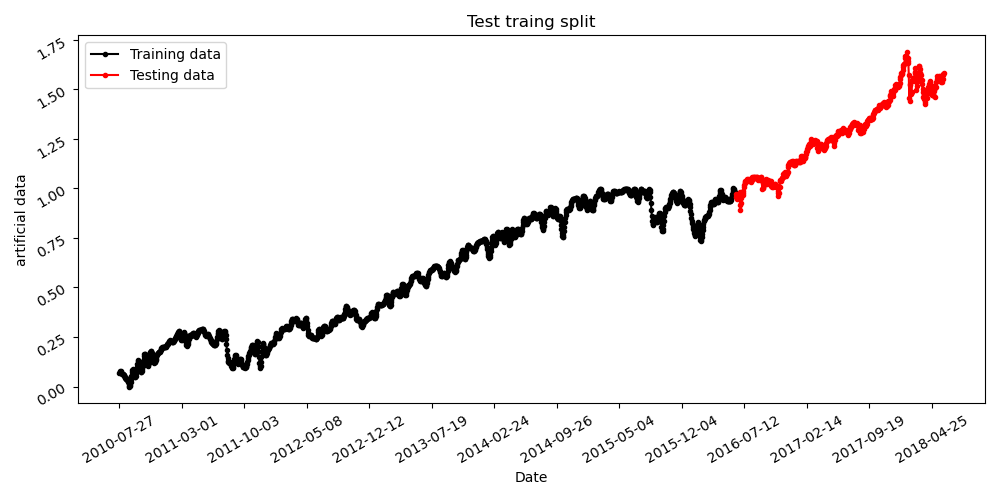

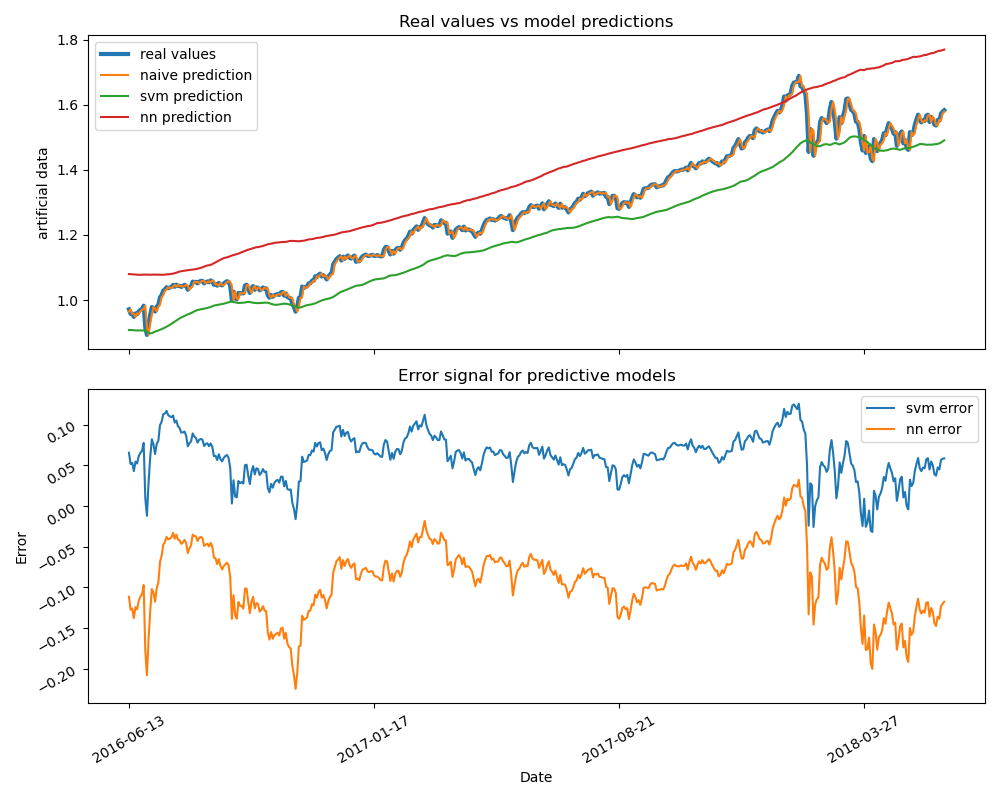

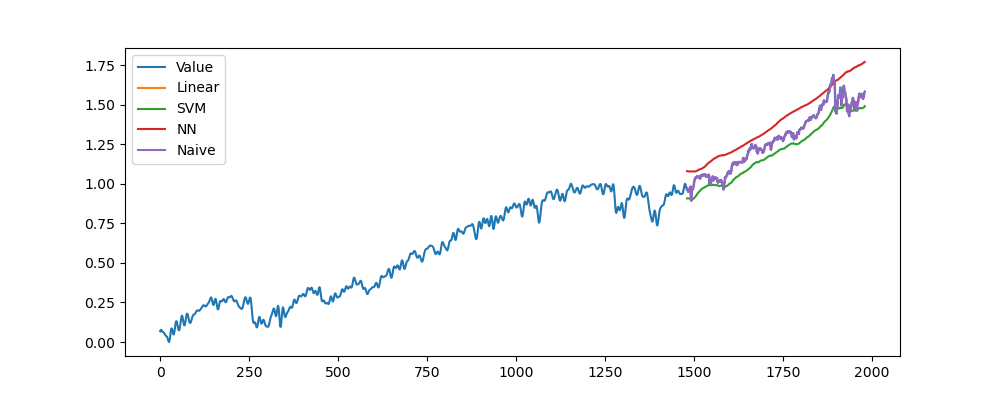

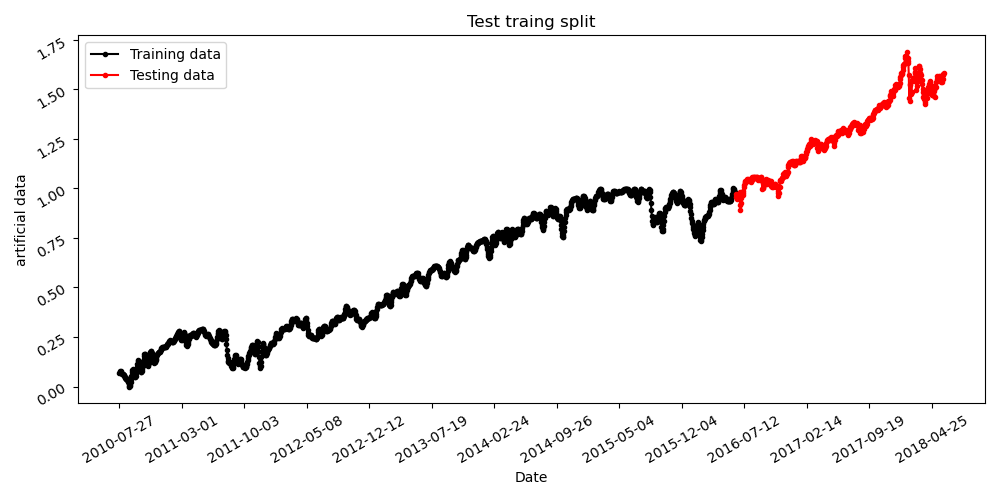

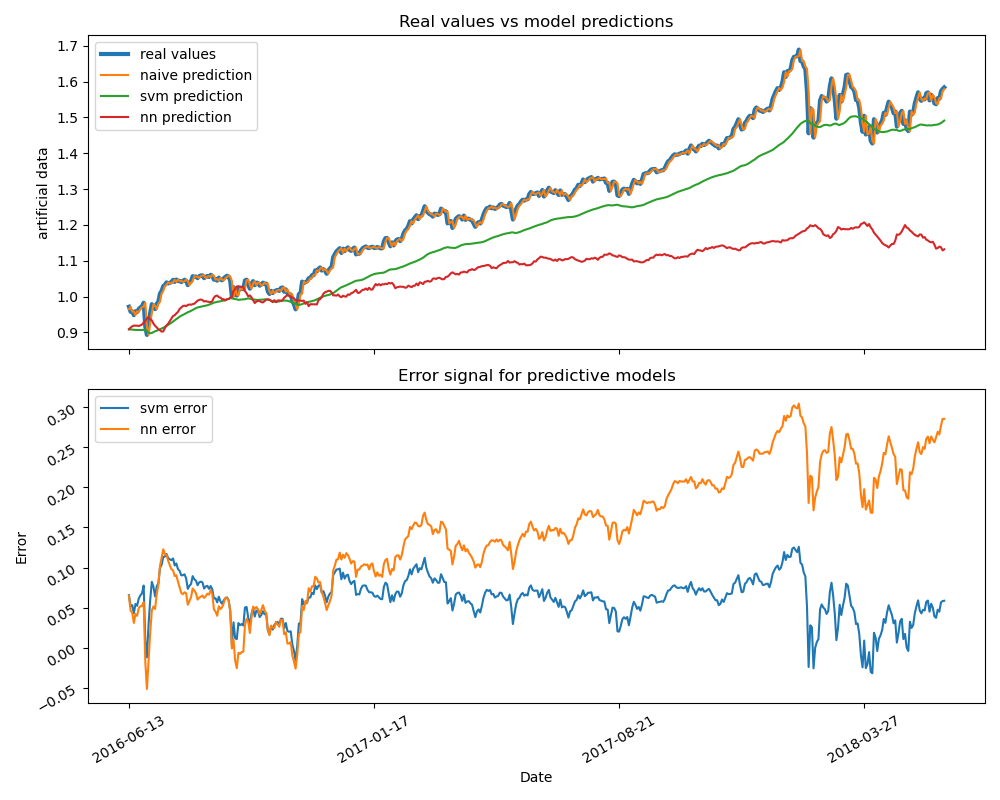

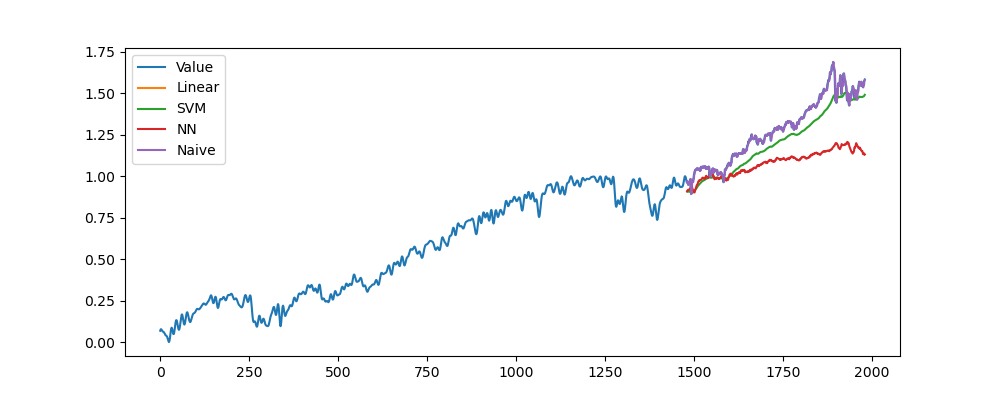

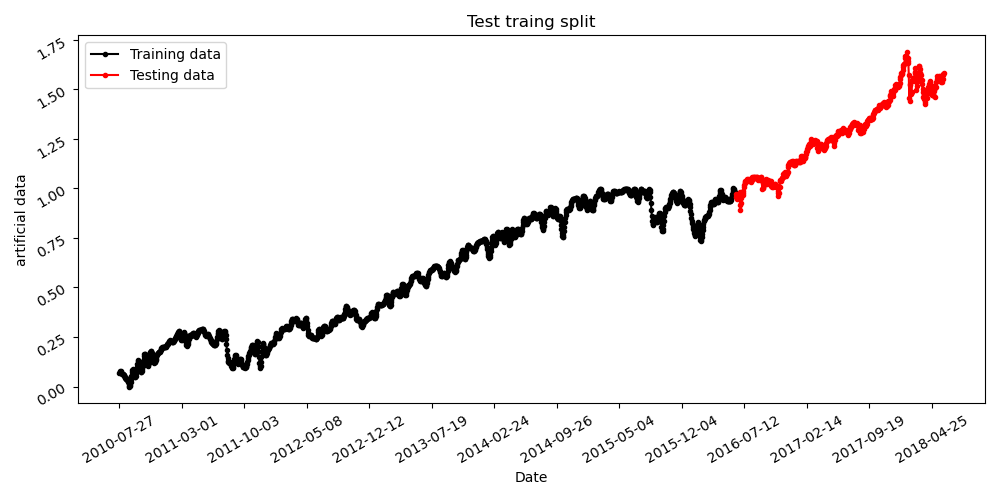

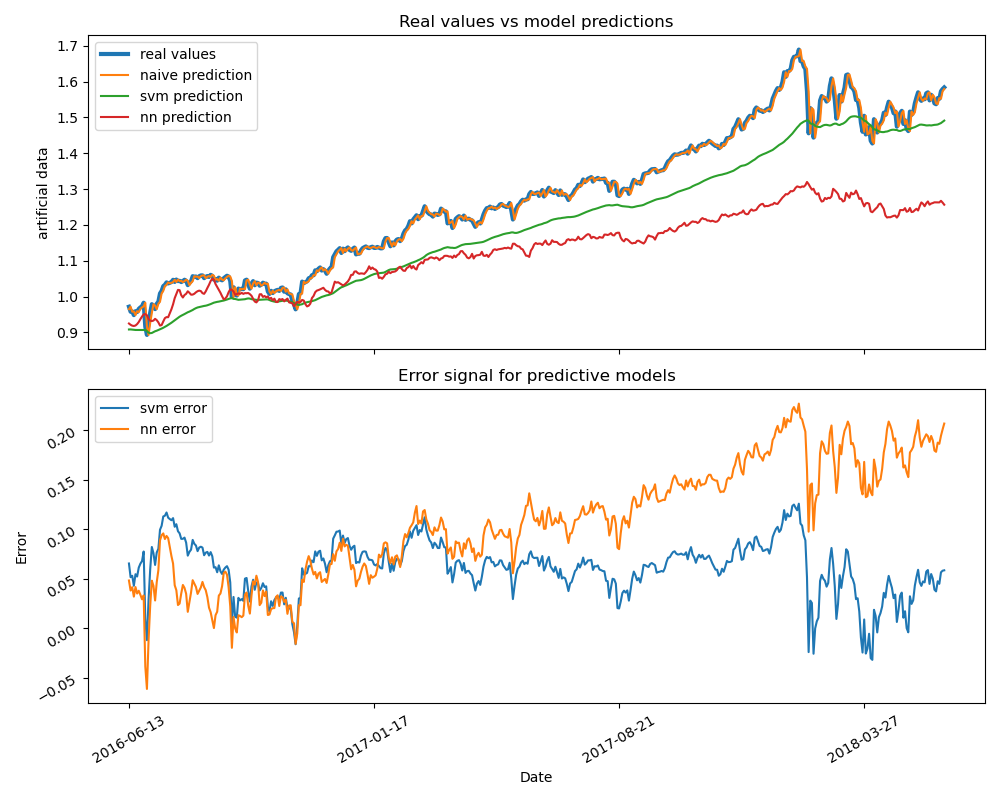

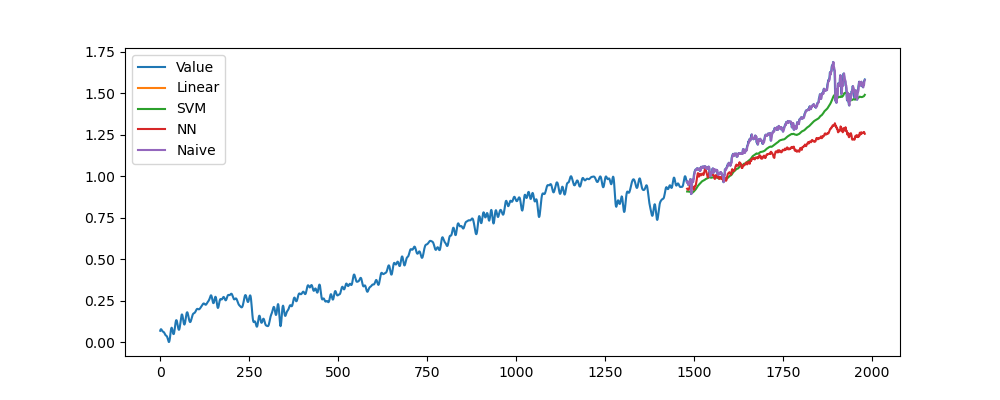

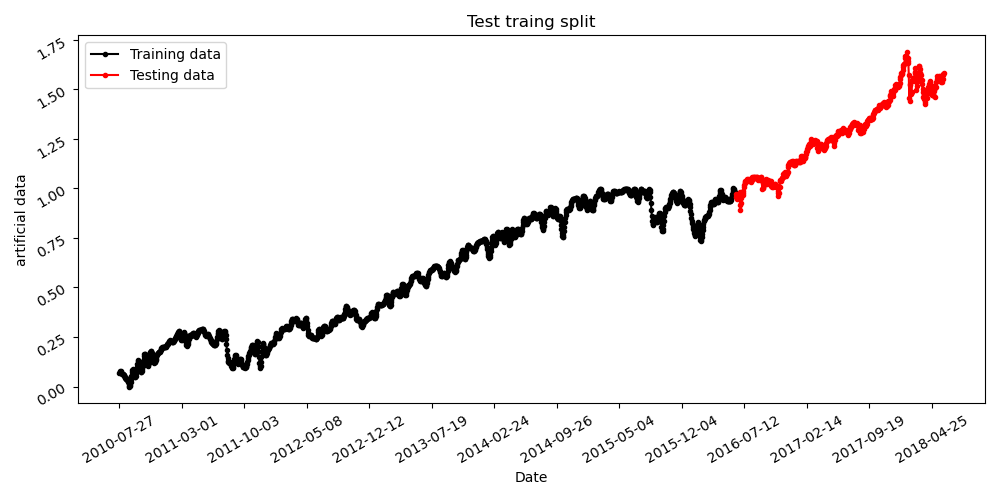

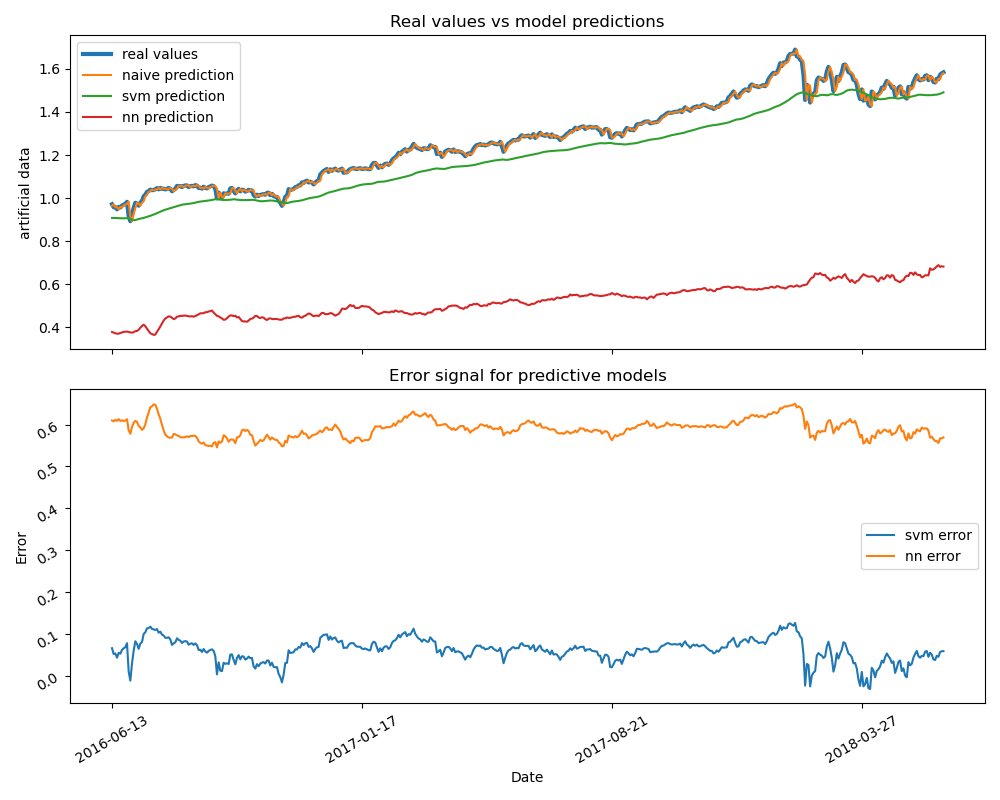

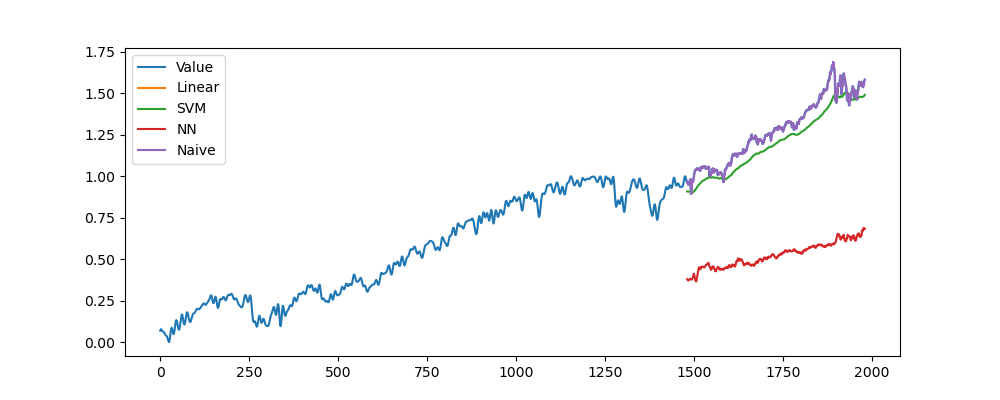

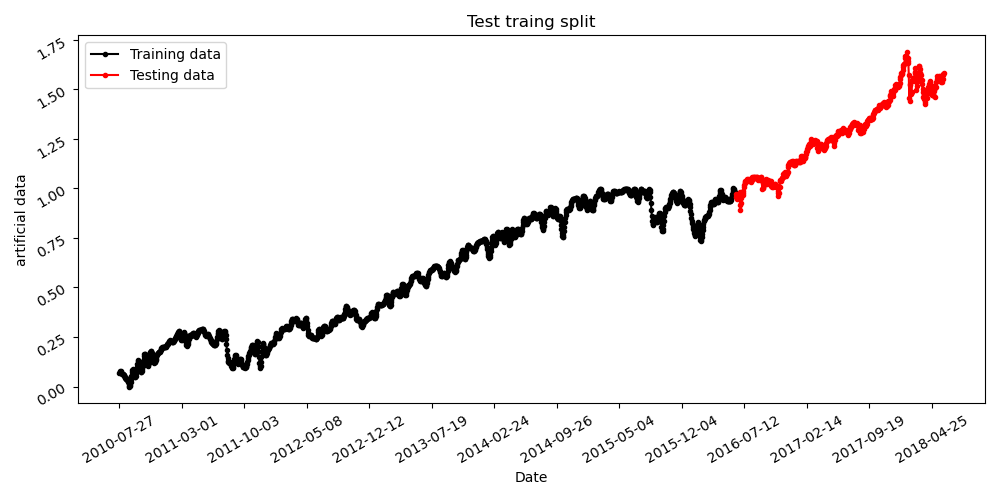

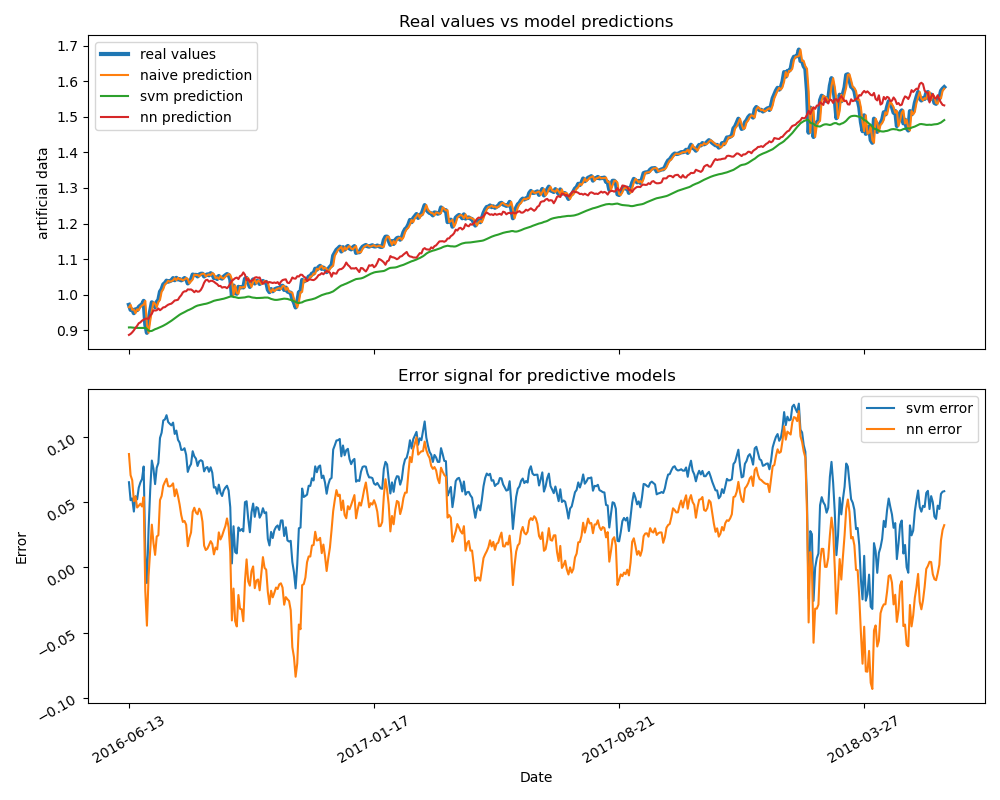

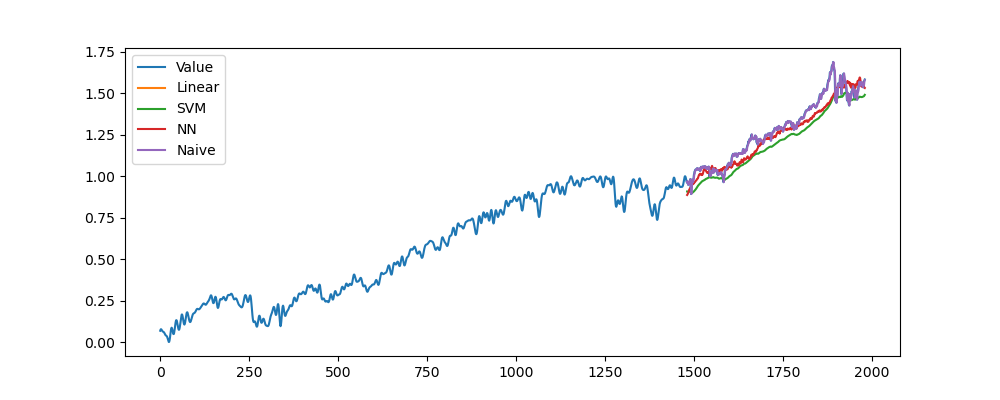

In [55]:
# repeat tests 15 times
models = []
for iteration in range(15):
    # model and forecast
    window_length = 150
    split = 500 

    ####################################################################################
    # scale and transform data
    ####################################################################################
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df_data['artificial_data'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df_data['artificial_data'][-split:].to_numpy().reshape(-1,1)).flatten()
    data = np.append(scaled_training_data,scaled_test_data)

    ####################################################################################
    # model and forecast
    ####################################################################################

    # initialize class object
    normal = time_series_prediction(df_data['Date'],data,window_length,1)# pass: time series dates, univariate time series, lag window length, a number of steps ahead to predict
    normal.sliding_window_1(verbose=0) # time series to supervised ML problem
    normal.train_test_split(split=split) # testing and training dataset split
    normal.test_train_plot(steps=150,ylabel='artificial data')    # visualize training split

    # perform some prediction tasks
    normal.naive_model()
    # normal.linear_regression()
    normal.support_vector_machine(model_tunning=True)
    normal.neural_net_mlp(model_tunning=True)

    ####################################################################################
    # visualize results
    ####################################################################################

    normal.vis_results_time_series(second_plot='error',ylabel='artificial data')

    ####################################################################################
    # tabulate results
    ####################################################################################
    tabulated_results_0 = normal.results()
    tabulated_results_0.plot(figsize=(10,4))
    display(tabulated_results_0)

    ####################################################################################
    # calculate directional accuracy
    ####################################################################################

    # data to feed to hit_rate function:
    dates = tabulated_results_0['date'].iloc[split+window_length:]
    original_values = tabulated_results_0['Value'].iloc[split+window_length:]
    lin_predictions = tabulated_results_0['Linear'].iloc[split+window_length:]
    svm_predictions = tabulated_results_0['SVM'].iloc[split+window_length:]
    nn_predictions =  tabulated_results_0['NN'].iloc[split+window_length:]
    naive_predictions =  tabulated_results_0['Naive'].iloc[split+window_length:]

    # hit rate calculations
    print('Linear Regression:')
    df_lin = hit_rate(dates,original_values,lin_predictions)

    print('SVM:')
    df_svm = hit_rate(dates,original_values,svm_predictions)

    print('NN:')
    df_nn = hit_rate(dates,original_values,nn_predictions)

    print('Naive:')
    df_naive = hit_rate(dates,original_values,naive_predictions)

    ####################################################################################
    # appends modelling results to list
    ####################################################################################
    
    models.append(normal)

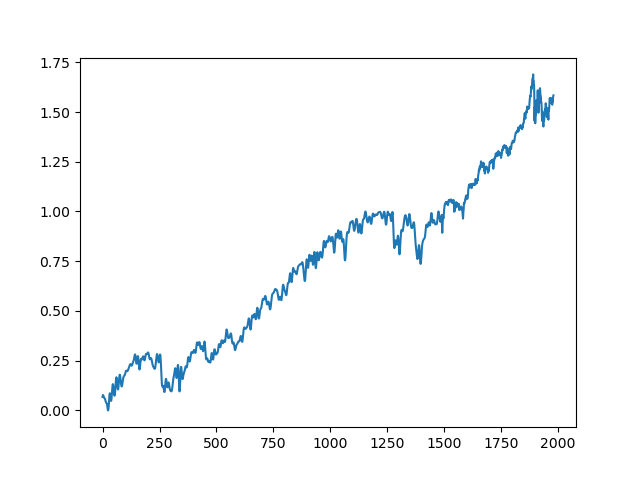

In [56]:
plt.figure()
plt.plot(normal.one_d_time_series)